# Analysis of bank customer churn

**Problem description:** recently, the bank has experienced a significant increase in customer churn, threatening its very existence.

**Customer:** Marketing Department - information is needed by the manager who oversees marketing campaigns and works closely with product managers.

**Need to obtain:** effective segmentation of churn customers so that they are homogeneous, highly accurate, and cover the maximum number of problem areas of the bank.

**Research purpose:** analyze the regional bank's customers and identify customer segments that tend to leave the bank.

**Data description:** dataset contains data on the bank's clients.
- `user_id` 
- `score`
- `сity` 
- `gender` 
- `age` 
- `equity`
- `balance`
- `products`
- `credit_card`
- `last_activity` 
- `est_salary` 
- `churn`. 


**The research will be conducted in 6 phases:**

1) Upload and review data: 

   - checking the correctness of column names;
   - checking for duplicates;
   - adding additional columns with encoded columns gender and city (using the pandas.get_dummies method);
   - investigating and determining the type of missing values (MCAR, MAR, MNAR);
   - checking for data type consistency;
   - checking for anomalies.


2) Exploratory analysis:
  
   - comparing quantitative customer profiles in terms of churn across all indicators;
   - distribution of continuous variables (in terms of churn);
   - analysis of the churn rate by categories;
   - correlation analysis.
   

3) Statistical hypothesis testing 

4) Interim conclusions: determination of a preliminary list of indicators that strategically influence churn, their values and intervals.

5) Segmentation based on strategic indicators: identify key characteristics that increase churn while reducing segmentation; prioritize segments.

6) Drawing conclusions and recommendations for the client, preparing a presentation.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

from scipy import stats as st
from statsmodels.stats.weightstats import ztest as ztest
import math as mth
import phik

import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None


## Upload and review data

In [2]:
# reading the scrooge.csv file with data and saving it to a variable 
path = "D:\scrooge.csv" 
data = pd.read_csv(path)

data.head()

USERID  score       city gender   age  equity     balance  products  \
0  183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1  146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2  120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3  225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4  157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  EST_SALARY  churn  
0            0              1    75719.14      1  
1            1              0    86621.77      0  
2            1              1   107683.34      0  
3            0              1   174423.53      1  
4            1              0    67353.16      1

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


**Result:** in the data 10000 records, there are gaps in the columns age and balance, it will be necessary to rename the columns USERID AND EST_SALARY for comfortable work, to bring the column age to type int.

### Columns renaming

In [4]:
# to lower columns name
data.columns = data.columns.str.lower()

# rename userid
data.rename(columns={'userid' : 'user_id'}, inplace=True)

data.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn  
0            0              1    75719.14      1  
1            1              0    86621.77      0  
2            1              1   107683.34      0  
3            0              1   174423.53      1  
4            1              0    67353.16      1

### Checking for duplicates

Check the entire dataset for obvious duplicates

In [5]:
data.duplicated().sum()

0

There are no duplicates. Let's check for duplicates in the `user_id` column, since this is the only field with unique values.

In [6]:
data['user_id'].duplicated().sum()

73

Found 73 records with the same values. Let's check duplicates by `user_id` again, but this time with `gender` column.

In [7]:
data[['user_id','gender']].duplicated().sum()

41

There were 41 matches. Let us assume that the same user is a customer of the bank in two different cities. Let's check the duplicates by `user_id` along with the `city` column.

In [8]:
data[['user_id', 'city']].duplicated().sum()

0

There are no duplicates. Let's add the `gender` column to check.

In [9]:
data[['user_id','gender','city']].duplicated().sum()

0

There are no duplicates based on the three columns - `user_id`, `gender`, `city`. Most likely, each city has its own database, so user ids may overlap when merging the data (using union all). In this case, the gender match can be considered random.

### Coding of `gender` and `city` columns

For the next steps in the study, it is necessary to convert categorical data into numerical data to be able to graph and investigate the correlation results.

In [10]:
# save gender column value
data['gender_1'] = data['gender'].copy()

# save city column value
data['city_1'] = data['city'].copy()

data.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn gender_1     city_1  
0            0              1    75719.14      1        Ж    Рыбинск  
1            1              0    86621.77      0        Ж    Рыбинск  
2            1              1   107683.34      0        Ж    Рыбинск  
3            0              1   174423.53      1        Ж  Ярославль  
4            1              0    67353.16      1        М  Ярославль

In [11]:
# code gender
data = pd.get_dummies(data, columns=['gender'])

# code city
data = pd.get_dummies(data, columns=['city'])

In [12]:
# rename columns
data.rename(columns={'gender_1':'gender',
                     'gender_М':'is_male',
                     'gender_Ж': 'is_female',
                     'city_1':'city',
                     'city_Ростов': 'is_Rostov',
                     'city_Рыбинск': 'is_Rybinsk',
                     'city_Ярославль':'is_Yaroslavl'}, inplace=True)

data.head()

user_id  score   age  equity     balance  products  credit_card  \
0   183012  850.0  25.0       1    59214.82         2            0   
1   146556  861.0  37.0       5   850594.33         3            1   
2   120722  892.0  30.0       0         NaN         1            1   
3   225363  866.0  51.0       5  1524746.26         2            0   
4   157978  730.0  34.0       5      174.00         1            1   

   last_activity  est_salary  churn gender       city  is_female  is_male  \
0              1    75719.14      1      Ж    Рыбинск          1        0   
1              0    86621.77      0      Ж    Рыбинск          1        0   
2              1   107683.34      0      Ж    Рыбинск          1        0   
3              1   174423.53      1      Ж  Ярославль          1        0   
4              0    67353.16      1      М  Ярославль          0        1   

   is_Rostov  is_Rybinsk  is_Yaroslavl  
0          0           1             0  
1          0           1             0  
2          0           1             0  
3          0           0             1  
4          0           0             1

### Missing Value Analysis 

#### Let's check for missing values in the `age` column.

In [13]:
data['age'].isna().sum()

26

There are only 26 skips - 0.26%. Let's see how they are distributed by `gender` and `city` columns.

In [14]:
nulls = data.query('age.isna() == True').groupby(['city', 'gender']).agg({'user_id':'count'})\
                                        .rename(columns={'user_id':'nulls'})
nulls

nulls
city      gender       
Ростов    Ж           1
Рыбинск   Ж           8
          М           4
Ярославль Ж           3
          М          10

It seems that men from Yaroslavl dont like to share the information about their age :)

In general, the gaps in the `age` column can be treated as random and filled with the median value based on `gender` and `city` of residence.

In [15]:
# female median age in Rostov 
rostov_age = data.query('is_Rostov == 1 & is_male == 0')['age'].median()

# female median age in Rybinsk
rybinsk_female = data.query('is_Rybinsk == 1 & is_male == 0')['age'].median()

# male median age in Rybinsk
rybinsk_male = data.query('is_Rybinsk == 1 & is_male == 1')['age'].median()

# female median age in Yaroslavl
yaroslavl_female = data.query('is_Yaroslavl == 1 & is_male == 0')['age'].median()

# male median age in Yaroslavl
yaroslavl_male = data.query('is_Yaroslavl == 1 & is_male == 1')['age'].median()


In [16]:
data.loc[((data['is_Rostov'] == 1) & (data['age'].isna() == True)), 'age'] = rostov_age

data.loc[((data['is_Rybinsk'] == 1) & (data['age'].isna() == True) & (data['is_male'] == 0)), 'age'] = rybinsk_female
data.loc[((data['is_Rybinsk'] == 1) & (data['age'].isna() == True) & (data['is_male'] == 1)), 'age'] = rybinsk_male

data.loc[((data['is_Yaroslavl'] == 1) & (data['age'].isna() == True) & (data['is_male'] == 0)), 'age'] = yaroslavl_female
data.loc[((data['is_Yaroslavl'] == 1) & (data['age'].isna() == True) & (data['is_male'] == 1)), 'age'] = yaroslavl_male

In [17]:
# cheking
data['age'].isna().sum()

0

#### Let's check for missing values in the `balance` column.

In [18]:
balance_nulls = data['balance'].isna().sum()

print(f'All gaps - {balance_nulls}, it is {balance_nulls/10000 * 100}% of all data.')

All gaps - 2295, it is 22.95% of all data.


Almost 23% skips, quite a high percentage. It is necessary to determine the type of skips and find an option for their processing. 

Let's look at the shares of skips when splitting by the *churn* parameter.

In [19]:
# dataset with null balance parameter
balance_nulls = data.query('balance.isna() == True')

balance_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2295 entries, 2 to 9997
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        2295 non-null   int64  
 1   score          2295 non-null   float64
 2   age            2295 non-null   float64
 3   equity         2295 non-null   int64  
 4   balance        0 non-null      float64
 5   products       2295 non-null   int64  
 6   credit_card    2295 non-null   int64  
 7   last_activity  2295 non-null   int64  
 8   est_salary     2295 non-null   float64
 9   churn          2295 non-null   int64  
 10  gender         2295 non-null   object 
 11  city           2295 non-null   object 
 12  is_female      2295 non-null   uint8  
 13  is_male        2295 non-null   uint8  
 14  is_Rostov      2295 non-null   uint8  
 15  is_Rybinsk     2295 non-null   uint8  
 16  is_Yaroslavl   2295 non-null   uint8  
dtypes: float64(4), int64(6), object(2), uint8(5)
memory 

In [20]:
balance_nulls.loc[balance_nulls['churn'] == 1, 'churn_str'] = 'churn'
balance_nulls.loc[balance_nulls['churn'] == 0, 'churn_str'] = 'no churn'

In [21]:
churn_grouped = balance_nulls.groupby('churn_str', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'nulls'})
churn_grouped

churn_str  nulls
0     churn     13
1  no churn   2282

In [22]:
fig = go.Figure(data=[go.Pie(labels = churn_grouped['churn_str'], values=churn_grouped['nulls'])])

fig.update_layout(title='Share of missing values by churn parameter',
                 legend_title_text='Parameter')

fig.show()

On the churn parameter, 99.4% of skips are observed for users who are *not churned*.

The entire analysis is based on the data with balance skips. The bar charts for the *products* and *equity* fields will show the total number and shares of skips, the histogram for the *est_salary* and *score* fields will show the distribution of skips by the binary parameters *last_activity* and *credit_card* for both types of charts. As a result, we will have 6 graphs for each parameter.

Let's create two functions: **get_grouped** - to create pivot tables for the required indicators, and **get_parameter_plots** - to create plots. 

In [23]:
def get_grouped(parameter_1, parameter_2):
    
    '''
    function to generate a pivot table by major and minor parameters 
    showing the total number and proportions of skips.
    '''
    
    full_nulls = balance_nulls.groupby(parameter_1, as_index=False).agg({'user_id':'count'})\
                        .rename(columns={'user_id':'full_nulls'})

    grouped = balance_nulls.groupby([parameter_1, parameter_2], as_index=False).agg({'user_id':'count'})\
                                .rename(columns={'user_id':'nulls'})\
                                .sort_values(by='nulls', ascending=False)

    grouped = grouped.merge(full_nulls, on=parameter_1, how='left')
    grouped['percentage'] = grouped['nulls']/grouped['full_nulls']


    return grouped

In [24]:
def get_parameter_plots(data_p, data_e, parameter_p, parameter_e, hue, subtitle, legend):
    
    '''
    function for plotting graphs showing: 
    total number and shares of skips by product and equity, 
    as well as the distribution of salaries and 
    credit scoring scores with a breakdown by specified hue
    
    '''
    
    plt.figure(figsize=(20, 18))

    plt.suptitle(f'Missing value analysis by {subtitle}', fontweight='bold', fontsize=15)
    sns.set_style('whitegrid')

    ax1 = plt.subplot(3, 2, 1)
    sns.barplot(x=parameter_p, y='percentage', data=data_p, hue=hue, palette='rocket', ax=ax1)
    plt.title('Share of passes by products')
    plt.xlabel('Number of products')
    plt.ylabel('Share of missing values')
    plt.legend(title=legend)

    ax2 = plt.subplot(3, 2, 2)
    sns.barplot(x=parameter_p, y='nulls', data=data_p, hue=hue, palette='rocket', ax=ax2)
    plt.title('Number of passes by products')
    plt.xlabel('Number of products')
    plt.ylabel('Number of missing values')
    plt.legend(title=legend)
    
    ax3 = plt.subplot(3, 2, 3)
    sns.barplot(x=parameter_e, y='percentage', data=data_e, hue=hue, palette='rocket', ax=ax3)
    plt.title('Share of passes by equity ')
    plt.xlabel('Number of equity')
    plt.ylabel('Share of missing values')
    plt.legend(title=legend)
    
    ax4 = plt.subplot(3, 2, 4)
    sns.barplot(x=parameter_e, y='nulls', data=data_e, hue=hue, palette='rocket', ax=ax4)
    plt.title('Number of passes by equity')
    plt.xlabel('Number of equity')
    plt.ylabel('Number of missing values')
    plt.legend(title=legend)

    ax5 = plt.subplot(3, 2, 5)
    sns.histplot(x='score', data=balance_nulls, kde=True, hue=hue, palette='mako', ax=ax5)
    plt.title('Distribution of passes by credit scoring')
    plt.xlabel('Credit score')
    plt.ylabel('Number')


    ax6 = plt.subplot(3, 2, 6)
    sns.histplot(x='est_salary', data=balance_nulls, kde=True, hue=hue, palette='mako', ax=ax6)
    plt.title('Distribution of passes by salary')
    plt.xlabel('Salary')
    plt.ylabel('Number')


    plt.show()

Let's consider skips in terms of users **last_activity**.

In [25]:
# products
p_grouped = get_grouped('products', 'last_activity')

display(p_grouped)

#equity
e_grouped = get_grouped('equity', 'last_activity')
e_grouped

products  last_activity  nulls  full_nulls  percentage
0         1              1   1083        1950    0.555385
1         1              0    867        1950    0.444615
2         2              1    170         315    0.539683
3         2              0    145         315    0.460317
4         3              0     21          29    0.724138
5         3              1      8          29    0.275862
6         0              0      1           1    1.000000

equity  last_activity  nulls  full_nulls  percentage
0       0              1   1199        2180     0.55000
1       0              0    981        2180     0.45000
2       1              1     62         114     0.54386
3       1              0     52         114     0.45614
4       3              0      1           1     1.00000

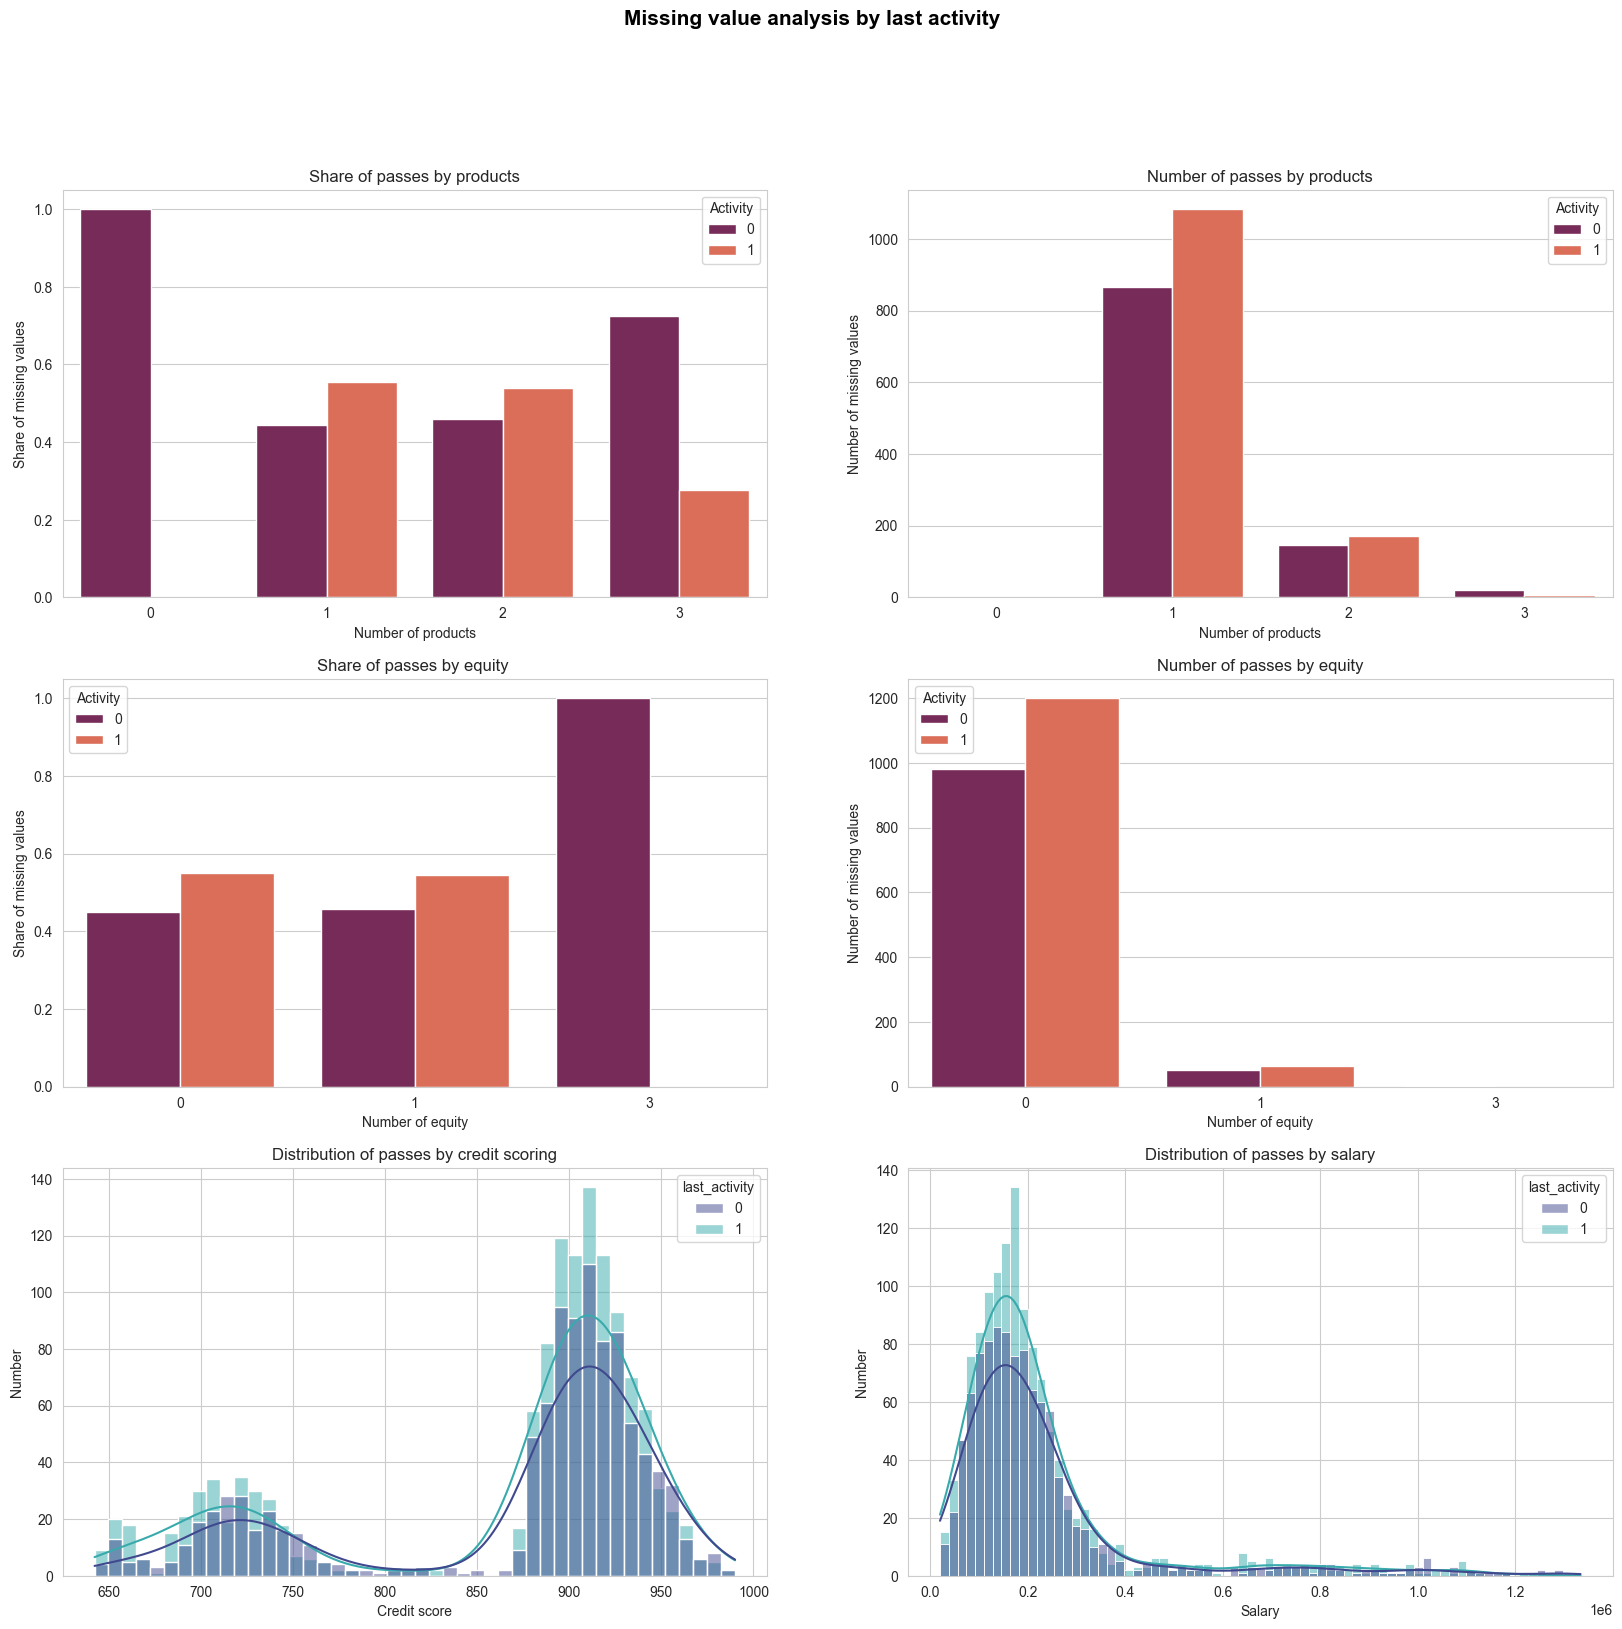

In [26]:
subtitle = 'last activity'
legend = 'Activity'
get_parameter_plots(p_grouped, e_grouped, 'products', 'equity','last_activity', subtitle, legend)

Observations:

- **Number of products:** users who use only *one* product are more likely to have an empty balance than others (almost 2000 passes), при этом - and these are **active** users (over 1000). If you look at pass shares, users with *one and two products* are also more likely to be *active*, but the ratio of shares is about 55 to 45 (i.e. almost the same). *Fewer skips* are found among users who have *0 or 3 products*, and are predominantly **not active**.
- **Number of equity:** over 2000 passes among users who **don't own any equity**, mostly - **active**, but the ratio of active/non-active shares is about 55% to 45%. Although skips are rare among users with *one equity*, they are also mostly **active** (same ratio of 55% to 45%). There's only one user with *three equities* and have empty balance, and he is **not active**.
- **Credit score**: let's say that the histogram split into two small ones. The most frequent unfilled balance is found in users with scoring between 650 and 800 and 850 and 1000 respectively, and those ranges are dominated by **active** users, but not too much.
- **Salary**: The histogram is bell-shaped with a peak around 200k with a pronounced long tail to the right, advantage of **active** users.


If you look at the number of skips by last activity, active users have the advantage. However, if we look at the shares, there is an almost equal percentage of both the number of products and the number of equity - about 55% active and 45% not active. Also here it is impossible to draw a correlation between the number of skips and the growth of the number of products or equities. 
There is a statistic that says that **the users with one product and zero equity have the most passes, with almost the same activity**.

Let's consider the skips in terms of **credit card**.

In [27]:
# products
p_grouped = get_grouped('products', 'credit_card')

display(p_grouped)

#equity
e_grouped = get_grouped('equity', 'credit_card')
e_grouped

products  credit_card  nulls  full_nulls  percentage
0         1            1   1599        1950    0.820000
1         1            0    351        1950    0.180000
2         2            1    257         315    0.815873
3         2            0     58         315    0.184127
4         3            1     16          29    0.551724
5         3            0     13          29    0.448276
6         0            0      1           1    1.000000

equity  credit_card  nulls  full_nulls  percentage
0       0            1   1775        2180    0.814220
1       0            0    405        2180    0.185780
2       1            1     97         114    0.850877
3       1            0     17         114    0.149123
4       3            0      1           1    1.000000

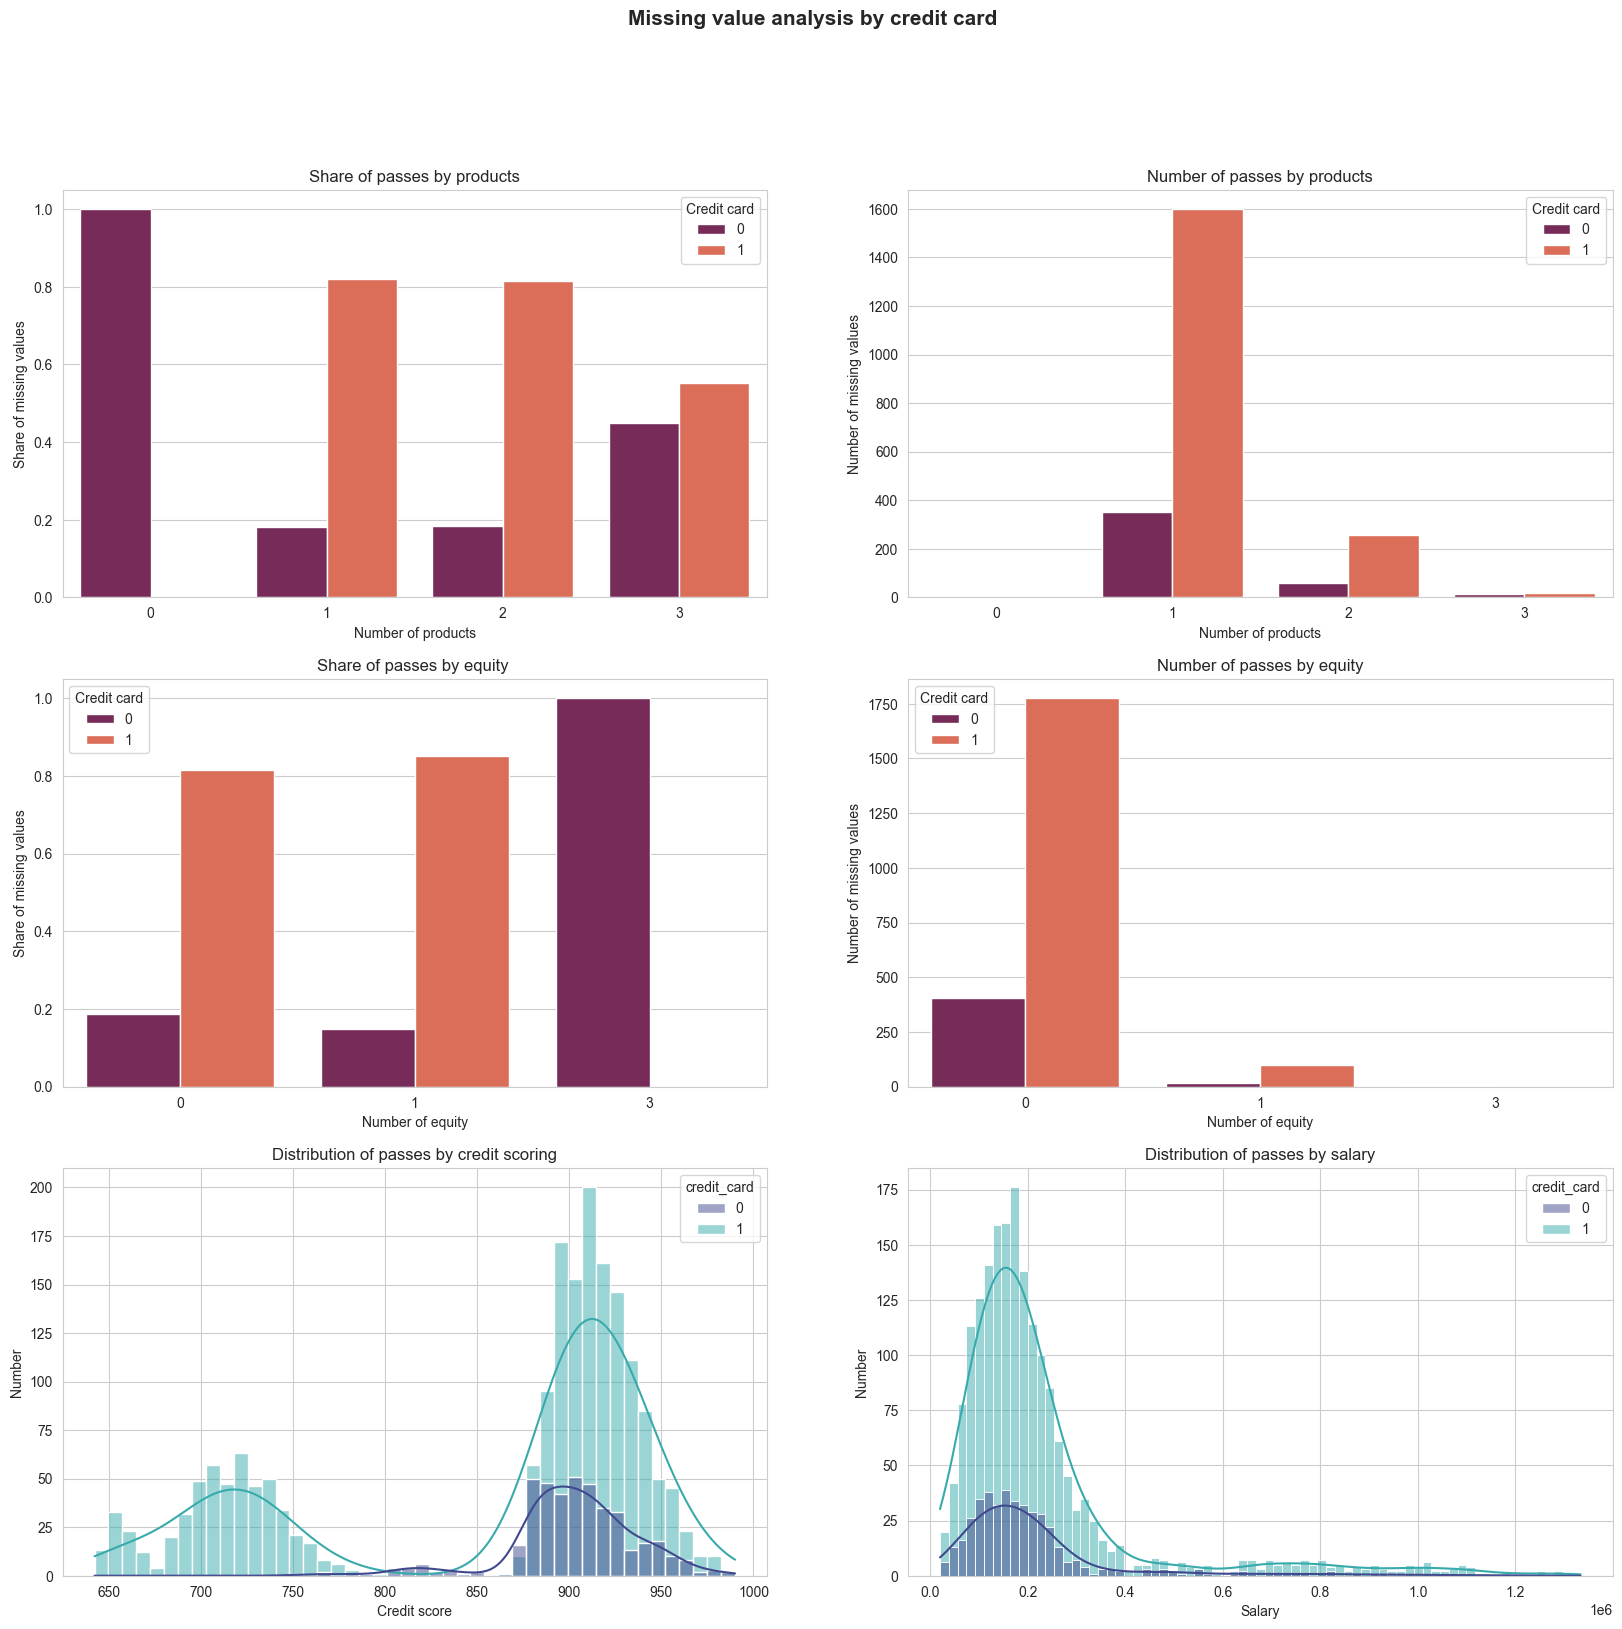

In [28]:
subtitle = 'credit card'
legend = 'Credit card'
get_parameter_plots(p_grouped, e_grouped, 'products', 'equity','credit_card', subtitle, legend)

Observations:

- **Number of products:** almost 2000 users with **one product* have **no balance** and just over 300 users with two products, most of them with **credit cards**. However, **shares of passes by credit card** have a greater variance in activity - approximately **about **82% of users with one and two products and a credit card have an unfilled balance**.
- **Number of equity:** more than *2 000 users* with an unfilled balance *have no equities*, just over *more than 100 have one equity*. For users with zero and one equity rates, skips are prevalent among those who **use a credit card**. But here, just as with the number of products, **proportions of passes by credit card availability dominate - over 80%**.
- **Credit score:** the histogram shows two pronounced "bells". The first has a range *from 650 to 800 points*, and these users use **exclusively credit cards**. The second "bell" is in the range *from 850 to 1000 points*, here the *no credit card* users are already there, but still a clear advantage for those using credit cards.
- **Salary:** we can say that the *histogram* is almost **"credit"**, the peak in terms of having/not having a credit card is around 200k, but the difference in numbers is huge - *more than 100*.

Unlike the activity parameter, here we see a **explicit correlation between having a credit card and the number of passes on the analyzed indicators - number of products, number of equity, credit score and salary**. We can see from the graphs that the main part of the skips are among users who use one product and no equity at all and among them **predominantly credit card users**. The same can be seen in the histograms, especially among users with lower scoring, among them exclusively those who **use a credit card**.

**Result**

Therefore, the conclusion can be that **the missing values are not accidental** - these are mostly users who are not going to stop using the bank's services (not churn) and use credit cards. There is an assumption that NAN misses in this case is a negative balance, but since we have no way to trace the difference in income-expense due to lack of information, this remains just an assumption.

The research goal is to investigate churn customers, so that we can leave the missing values. Let's just keep in mind that there is a category of presumptive "debtors" among the non-churn.


### Work with data types

Convert the float type of the `age` column to int.

In [29]:
data['age'] = data['age'].astype('int')

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   age            10000 non-null  int32  
 3   equity         10000 non-null  int64  
 4   balance        7705 non-null   float64
 5   products       10000 non-null  int64  
 6   credit_card    10000 non-null  int64  
 7   last_activity  10000 non-null  int64  
 8   est_salary     10000 non-null  float64
 9   churn          10000 non-null  int64  
 10  gender         10000 non-null  object 
 11  city           10000 non-null  object 
 12  is_female      10000 non-null  uint8  
 13  is_male        10000 non-null  uint8  
 14  is_Rostov      10000 non-null  uint8  
 15  is_Rybinsk     10000 non-null  uint8  
 16  is_Yaroslavl   10000 non-null  uint8  
dtypes: float64(3), int32(1), int64(6), object(2), uint8

### Anomaly research

In [31]:
def get_characteristic(parameter, title):
    
    display(data[parameter].describe())
    print()
    
    plt.figure(figsize=(15, 5))
    sns.histplot(x=parameter, data=data, palette='mako')
    plt.title(title)
    plt.xlabel('')
    if parameter == 'balance_1':
        plt.xlim(0,10)
    if parameter == 'est_salary_1':
        plt.xlim(0,1000)
    plt.ylabel('Number')

**Number of equity**

count    10000.000000
mean         2.627600
std          1.980836
min          0.000000
25%          0.000000
50%          3.000000
75%          4.000000
max          9.000000
Name: equity, dtype: float64

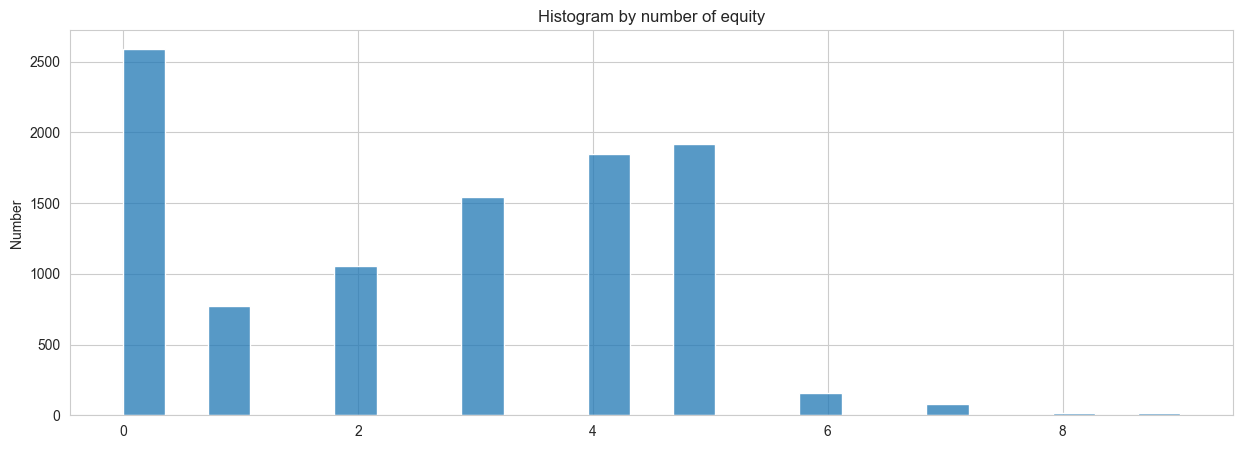

In [32]:
title = 'Histogram by number of equity'
get_characteristic('equity', title)

In [33]:
data.query('equity >= 8')['user_id'].count()

30

**Number of products**

count    10000.000000
mean         1.870100
std          0.792647
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          5.000000
Name: products, dtype: float64

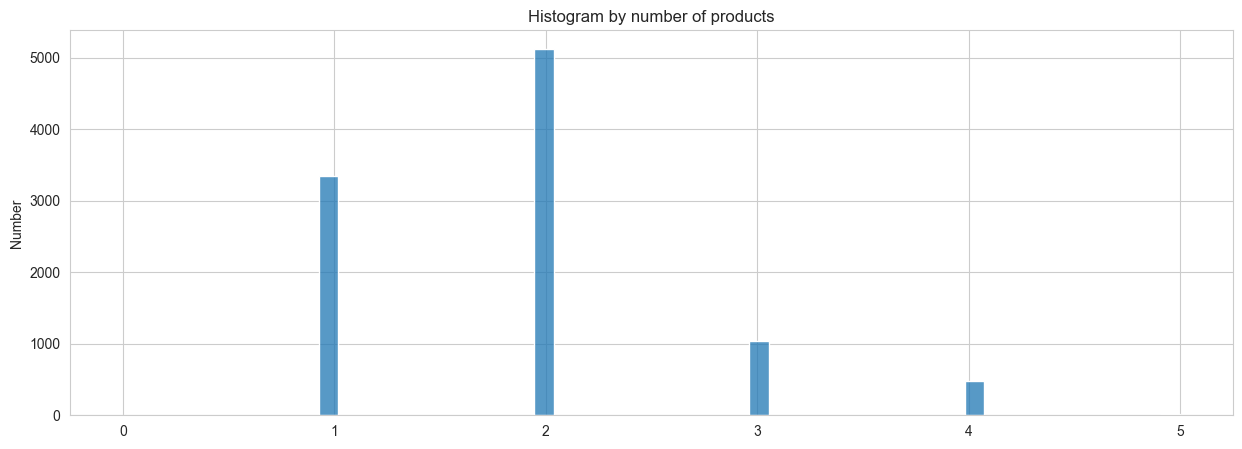

In [34]:
title = 'Histogram by number of products'
get_characteristic('products', title)

In [35]:
data.query('products == 0')['user_id'].count()

1

In [36]:
data.query('products == 5')['user_id'].count()

19

**Credit score**

count    10000.000000
mean       848.699400
std         65.448519
min        642.000000
25%        802.000000
50%        853.000000
75%        900.000000
max       1000.000000
Name: score, dtype: float64

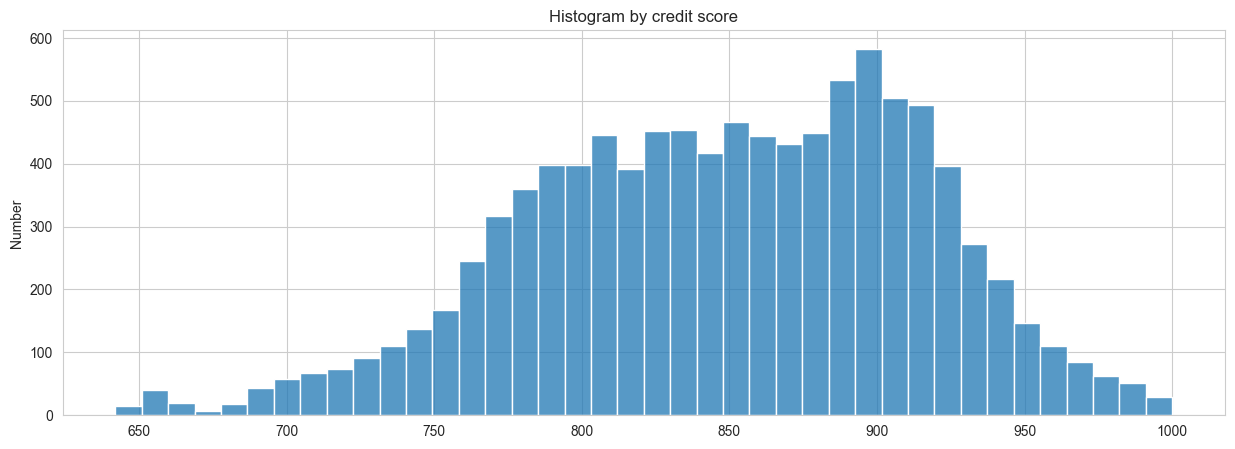

In [37]:
title = 'Histogram by credit score'
get_characteristic('score', title)

In [38]:
data.query('score < 700')['user_id'].count()

170

**Balance**

count    7705.000000
mean        0.827794
std         1.980614
min         0.000000
25%         0.295554
50%         0.524272
75%         0.980706
max       119.113552
Name: balance_1, dtype: float64

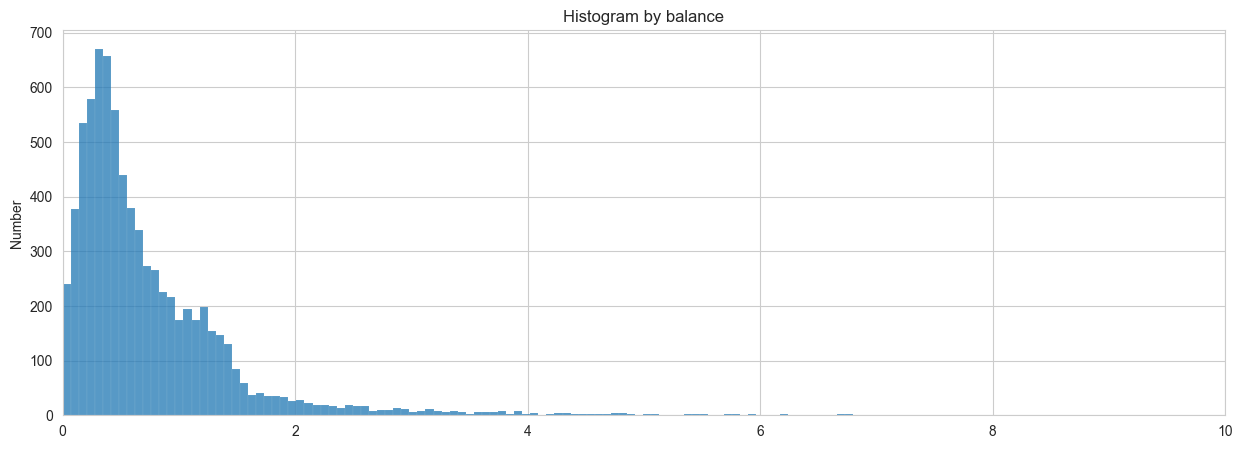

In [39]:
data['balance_1'] = data['balance'] / 1000000
title = 'Histogram by balance'
get_characteristic('balance_1', title)

In [40]:
data.query('balance_1 > 100')['user_id'].count()

1

**Salary**

count    10000.000000
mean       147.866886
std        139.388511
min          2.546300
25%         75.251900
50%        119.658105
75%        174.500542
max       1395.064450
Name: est_salary_1, dtype: float64

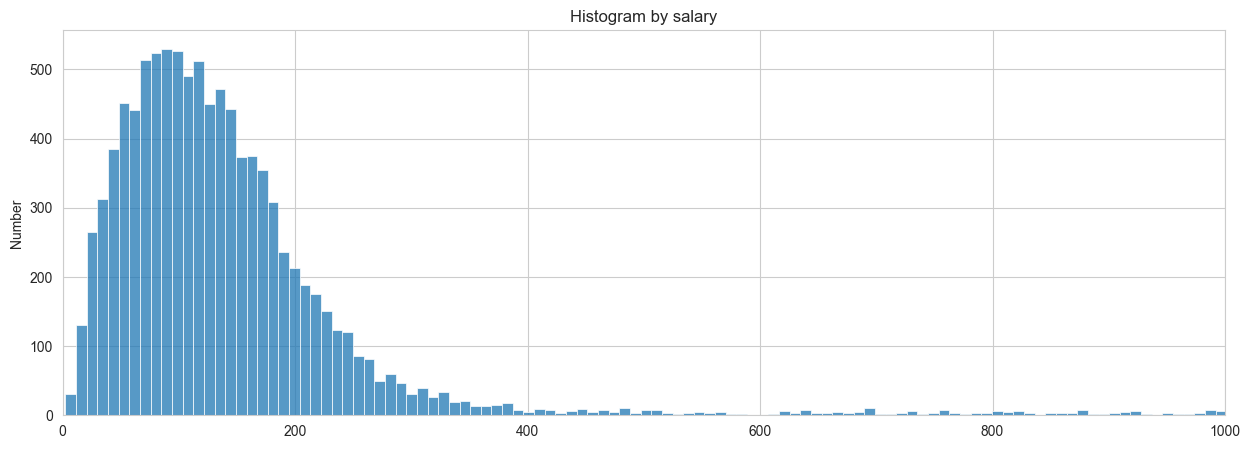

In [41]:
data['est_salary_1'] = data['est_salary'] / 1000
title = 'Histogram by salary'
get_characteristic('est_salary_1', title)

In [42]:
data.query('est_salary_1 > 1000')['user_id'].count()

59

**Age**

count    10000.000000
mean        42.729200
std         12.165355
min         18.000000
25%         33.000000
50%         40.000000
75%         51.000000
max         86.000000
Name: age, dtype: float64

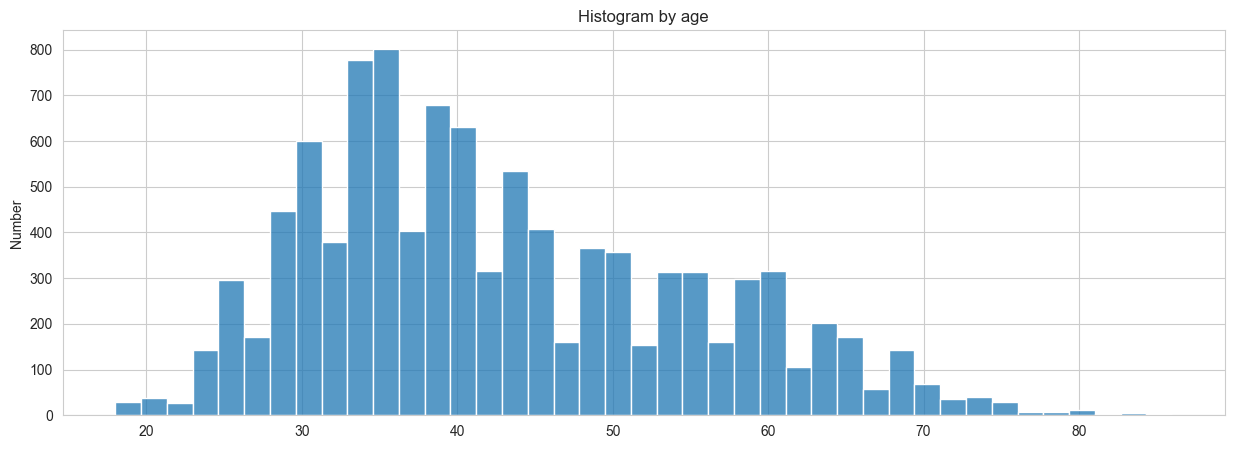

In [43]:
title = 'Histogram by age'
get_characteristic('age', title)

In [44]:
data.query('age > 80')['user_id'].count()

13

In [45]:
data = data.query('products != 0')

**Observations**:

- There are no abnormally low (negative) values such as age, credit balance, or salary.
- Balance and salary have very long tails, lots of outliers.
- The two largest values by equity are 8, 9 - totaly such users only 30.
- The max number of products - 5, such users only 19. There is one user who has 0 products, in terms of analyzing the bank's metrics he is redundant, so he was removed.

## Exploratory analysis

Let's look at the percentage split of churn and non churn users.

In [46]:
churn_grouped = data.groupby('churn', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'users'})
churn_grouped.loc[churn_grouped['churn'] == 1, 'churn_str'] = 'Churn'
churn_grouped.loc[churn_grouped['churn'] == 0, 'churn_str'] = 'Not churn'
churn_grouped

churn  users  churn_str
0      0   8180  Not churn
1      1   1819      Churn

In [47]:
fig = go.Figure(data=[go.Pie(labels = churn_grouped['churn_str'], values=churn_grouped['users'])])

fig.update_layout(title='Доли отточности',
                 legend_title_text='Отточность')

fig.show()

18% churn rate!

For further analytical manipulations, let's split the dataframe into two: churn and not_churn. 

In [48]:
churn = data.query('churn == 1')

churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1819 entries, 0 to 9994
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        1819 non-null   int64  
 1   score          1819 non-null   float64
 2   age            1819 non-null   int32  
 3   equity         1819 non-null   int64  
 4   balance        1807 non-null   float64
 5   products       1819 non-null   int64  
 6   credit_card    1819 non-null   int64  
 7   last_activity  1819 non-null   int64  
 8   est_salary     1819 non-null   float64
 9   churn          1819 non-null   int64  
 10  gender         1819 non-null   object 
 11  city           1819 non-null   object 
 12  is_female      1819 non-null   uint8  
 13  is_male        1819 non-null   uint8  
 14  is_Rostov      1819 non-null   uint8  
 15  is_Rybinsk     1819 non-null   uint8  
 16  is_Yaroslavl   1819 non-null   uint8  
 17  balance_1      1807 non-null   float64
 18  est_sala

In [49]:
not_churn = data.query('churn == 0')

not_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8180 entries, 1 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        8180 non-null   int64  
 1   score          8180 non-null   float64
 2   age            8180 non-null   int32  
 3   equity         8180 non-null   int64  
 4   balance        5898 non-null   float64
 5   products       8180 non-null   int64  
 6   credit_card    8180 non-null   int64  
 7   last_activity  8180 non-null   int64  
 8   est_salary     8180 non-null   float64
 9   churn          8180 non-null   int64  
 10  gender         8180 non-null   object 
 11  city           8180 non-null   object 
 12  is_female      8180 non-null   uint8  
 13  is_male        8180 non-null   uint8  
 14  is_Rostov      8180 non-null   uint8  
 15  is_Rybinsk     8180 non-null   uint8  
 16  is_Yaroslavl   8180 non-null   uint8  
 17  balance_1      5898 non-null   float64
 18  est_sala

### Comparing quantitative customer profiles in terms of churn across all indicators

Let's look at the descriptive statistics of continuous and categorical variables.

**Continuous:** score, age, equity, products, balance_1, est_salary_1. 

**Categoricals in binary format:** credit_card, last_activity, is_male, is_Rostov, is_Rybinsk, is_Yaroslavl.

In [50]:
# dataframe with descriptive statistics on churn users
churn_df = churn.describe()
churn_df = churn_df.drop(['user_id', 'balance', 'est_salary', 'churn'], axis=1)
churn_df

score          age       equity     products  credit_card  \
count  1819.000000  1819.000000  1819.000000  1819.000000  1819.000000   
mean    863.346894    41.431556     3.764156     2.377130     0.551402   
std      49.571209    11.142003     1.586144     0.921951     0.497488   
min     706.000000    18.000000     0.000000     1.000000     0.000000   
25%     828.000000    32.000000     3.000000     2.000000     0.000000   
50%     866.000000    39.000000     4.000000     2.000000     1.000000   
75%     898.000000    52.000000     5.000000     3.000000     1.000000   
max    1000.000000    75.000000     9.000000     5.000000     1.000000   

       last_activity    is_female      is_male    is_Rostov   is_Rybinsk  \
count    1819.000000  1819.000000  1819.000000  1819.000000  1819.000000   
mean        0.702584     0.349643     0.650357     0.146234     0.239692   
std         0.457247     0.476988     0.476988     0.353438     0.427013   
min         0.000000     0.000000     0.000000     0.000000     0.000000   
25%         0.000000     0.000000     0.000000     0.000000     0.000000   
50%         1.000000     0.000000     1.000000     0.000000     0.000000   
75%         1.000000     1.000000     1.000000     0.000000     0.000000   
max         1.000000     1.000000     1.000000     1.000000     1.000000   

       is_Yaroslavl    balance_1  est_salary_1  
count   1819.000000  1807.000000   1819.000000  
mean       0.614074     1.133993    148.310728  
std        0.486947     2.033978    122.914344  
min        0.000000     0.000006     10.880270  
25%        0.000000     0.387218     83.196615  
50%        1.000000     0.782410    125.395220  
75%        1.000000     1.348101    175.985385  
max        1.000000    64.866210   1263.028490

In [51]:
# dataframe with descriptive statistics on not churn users
not_churn_df = not_churn.describe()
not_churn_df = not_churn_df.drop(['user_id', 'balance', 'est_salary','churn'], axis=1)
not_churn_df

score          age       equity     products  credit_card  \
count  8180.000000  8180.000000  8180.000000  8180.000000  8180.000000   
mean    845.428362    43.013325     2.374817     1.757579     0.709169   
std      68.047721    12.357898     1.971394     0.713371     0.454174   
min     642.000000    18.000000     0.000000     1.000000     0.000000   
25%     796.000000    34.000000     0.000000     1.000000     0.000000   
50%     848.000000    40.000000     3.000000     2.000000     1.000000   
75%     900.000000    51.000000     4.000000     2.000000     1.000000   
max    1000.000000    86.000000     9.000000     5.000000     1.000000   

       last_activity    is_female      is_male    is_Rostov   is_Rybinsk  \
count    8180.000000  8180.000000  8180.000000  8180.000000  8180.000000   
mean        0.483741     0.532763     0.467237     0.140709     0.276039   
std         0.499766     0.498956     0.498956     0.347742     0.447064   
min         0.000000     0.000000     0.000000     0.000000     0.000000   
25%         0.000000     0.000000     0.000000     0.000000     0.000000   
50%         0.000000     1.000000     0.000000     0.000000     0.000000   
75%         1.000000     1.000000     1.000000     0.000000     1.000000   
max         1.000000     1.000000     1.000000     1.000000     1.000000   

       is_Yaroslavl    balance_1  est_salary_1  
count   8180.000000  5898.000000   8180.000000  
mean       0.583252     0.733983    147.783200  
std        0.493051     1.954573    142.802379  
min        0.000000     0.000000      2.546300  
25%        0.000000     0.279349     73.506152  
50%        1.000000     0.475382    118.257715  
75%        1.000000     0.853927    173.990125  
max        1.000000   119.113552   1395.064450

For *continuous variables* we will use *median*, for categorical - *mean*, as they are represented in binary format, so they will reflect the proportion of values taking one.

Let's write a function to compare the median, where the index will take the values "50%" or "mean", the column is a parameter, the value of which will compare between the churned and non churned dataframes.

- by how many percent the median value of a churned continuous variable (is_category = False) is greater than the median value of a non-churned variable; 
- by how many percent the average value of a churned binary variable is greater than the average value of a non-churned binary variable (is_category = True).

In [52]:
def get_percent_diff(parameters, is_category, dict_):
    if is_category:
        print(f'Comparison of categorical variables')
        print()
        for param in parameters:
            print(f'Comparison of mean value {param}')
            result = round(churn_df.loc['mean', param] / not_churn_df.loc['mean', param] * 100 - 100, 2)
            print(f'The difference is {result}%')
            print()
            dict_[param] = result
    else:
        print('Comparison of continuous variables')
        print()
        for param in parameters:
            print(f'Comparison of mean value {param}')
            result = round(churn_df.loc['50%', param] / not_churn_df.loc['50%', param] * 100 - 100, 2)
            print(f'The difference is {result}%')
            print()
            dict_[param] = result            

In [53]:
cont_dict = {}
params = ['score','balance_1', 'est_salary_1', 'equity', 'products', 'age']
get_percent_diff(params, False, cont_dict)

Comparison of continuous variables

Comparison of mean value score
The difference is 2.12%

Comparison of mean value balance_1
The difference is 64.59%

Comparison of mean value est_salary_1
The difference is 6.04%

Comparison of mean value equity
The difference is 33.33%

Comparison of mean value products
The difference is 0.0%

Comparison of mean value age
The difference is -2.5%



In [54]:
cont_df = pd.DataFrame(cont_dict, index=[0])
cont_df = cont_df.T.reset_index().rename(columns={0:'median', 'index':'parameter'})\
          .sort_values(by='median', ascending=False)
cont_df

parameter  median
1     balance_1   64.59
3        equity   33.33
2  est_salary_1    6.04
0         score    2.12
4      products    0.00
5           age   -2.50

In [55]:
category_dict = {}
params = ['last_activity','credit_card', 'is_male', 'is_female', 'is_Rostov', 'is_Rybinsk', 'is_Yaroslavl']
get_percent_diff(params, True, category_dict)

Comparison of categorical variables

Comparison of mean value last_activity
The difference is 45.24%

Comparison of mean value credit_card
The difference is -22.25%

Comparison of mean value is_male
The difference is 39.19%

Comparison of mean value is_female
The difference is -34.37%

Comparison of mean value is_Rostov
The difference is 3.93%

Comparison of mean value is_Rybinsk
The difference is -13.17%

Comparison of mean value is_Yaroslavl
The difference is 5.28%



In [56]:
category_df = pd.DataFrame(category_dict, index=[0])
category_df = category_df.T.reset_index().rename(columns={0:'mean', 'index':'parameter'})\
          .sort_values(by='mean', ascending=False)
category_df

parameter   mean
0  last_activity  45.24
2        is_male  39.19
6   is_Yaroslavl   5.28
4      is_Rostov   3.93
5     is_Rybinsk -13.17
1    credit_card -22.25
3      is_female -34.37

**Result**

Among the **churn** the following features are advantageous: 

 - balance - the difference is 64.59%, 
 - last activity  - 45.24%
 - men - 39.19%
 - number of equity - 33.33%
 - salary - 6.04%
 - Yaroslavl - 5.28%
 - Rostov - 3.93%
 - credit score - 2.12%
 
Among the **not churn**:

 - women - 34.37%
 - having credit card - 22.25%
 - Rybinsk - 13.17%
 - age - 2.5%

**Definitely have an effect on outflow: balance, last activity, number of equity - all these variables have an advantage of more than 30% over not churn variables.** Will also keep in mind that there are more current users in Yaroslavl and Rostov, and they are predominantly men; **an important preference among not churn is the availability of a credit card**.

### Distribution of continuous variables (in terms of churn parameter)

For variables with a large number of unique values - balance, score, est_salary, and age - let's make the distribution plots in terms of churn parameter.

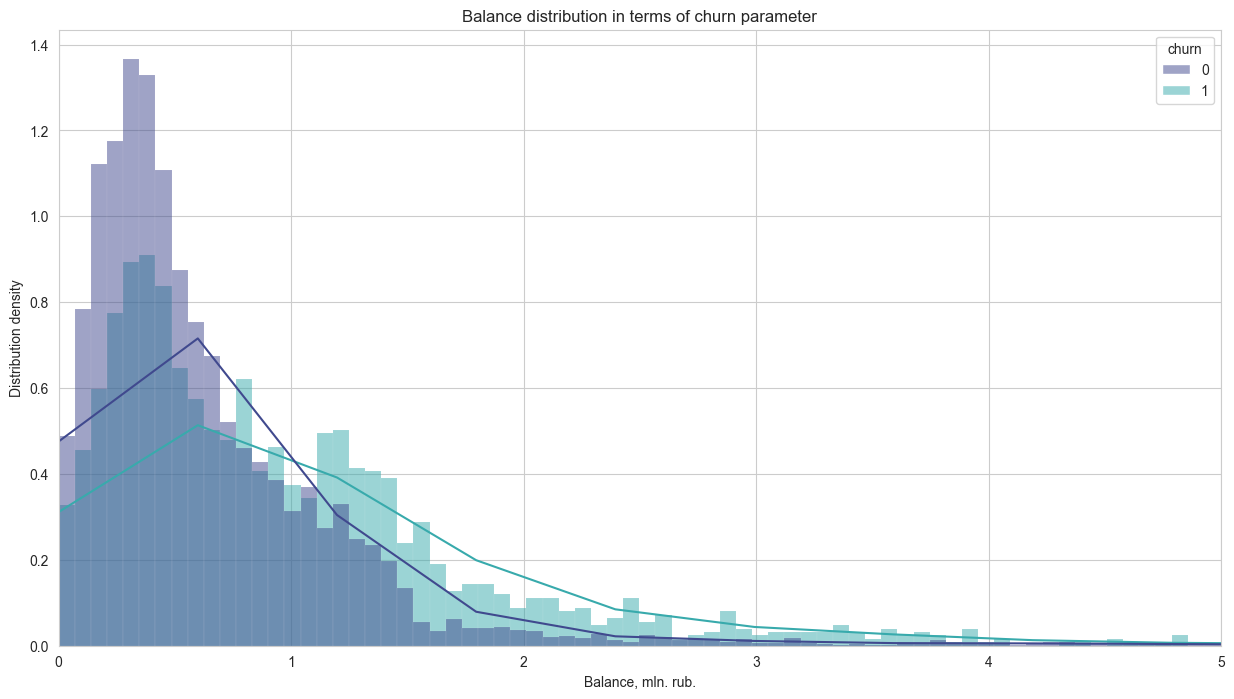

In [57]:
plt.figure(figsize=(15,8))

sns.histplot(x='balance_1', data=data, kde=True, hue='churn', palette='mako', stat="density", common_norm=False)
plt.title('Balance distribution in terms of churn parameter')
plt.xlim(0,5)
plt.ylabel('Distribution density')
plt.xlabel('Balance, mln. rub.')
plt.show()

- Based on the graph, we can see that **beginning with 1 million on the balance sheet, churn is clearly prevalent**. 
- **Not churn** users are predominantly those with balances up to 1 million.

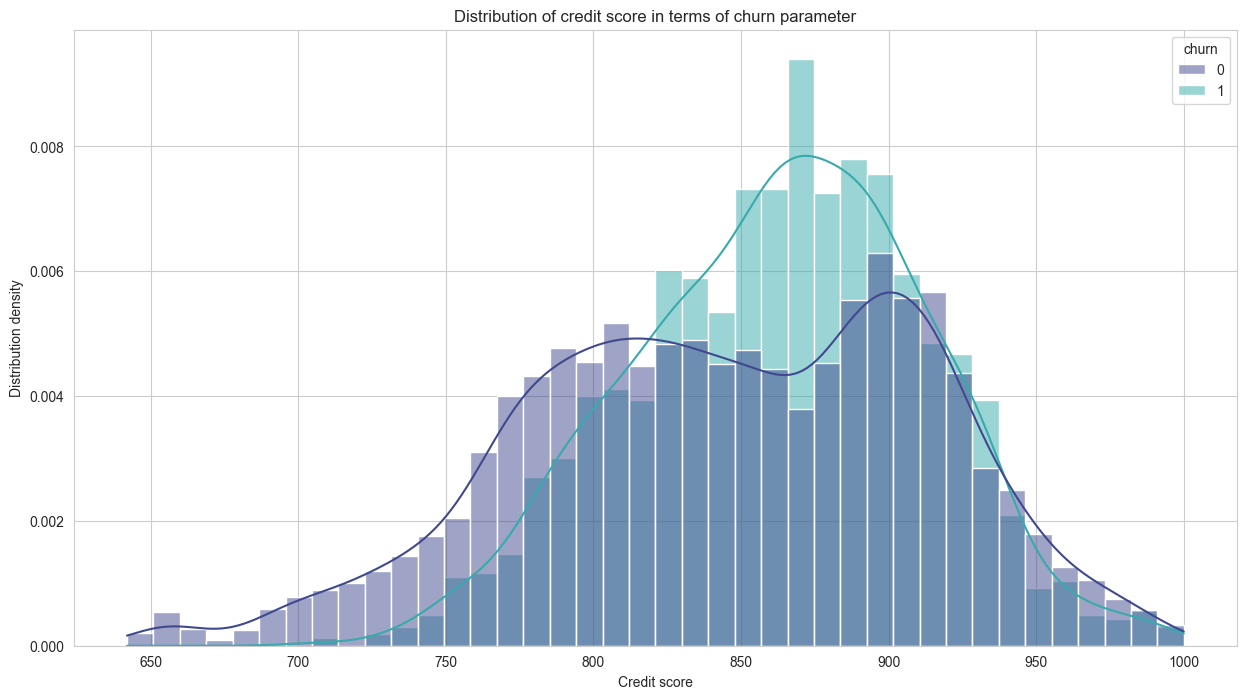

In [58]:
plt.figure(figsize=(15,8))

sns.histplot(x='score', data=data, kde=True, hue='churn', palette='mako', stat="density", common_norm=False)
plt.title('Distribution of credit score in terms of churn parameter')
plt.ylabel('Distribution density')
plt.xlabel('Credit score')
plt.show()

- Peak among **churn data** is **credit scores in the range of 830 to 940**.
- Two ranges can be distinguished among the **not churn**: **from 650 to 800** and **from 900 to 1000** points.

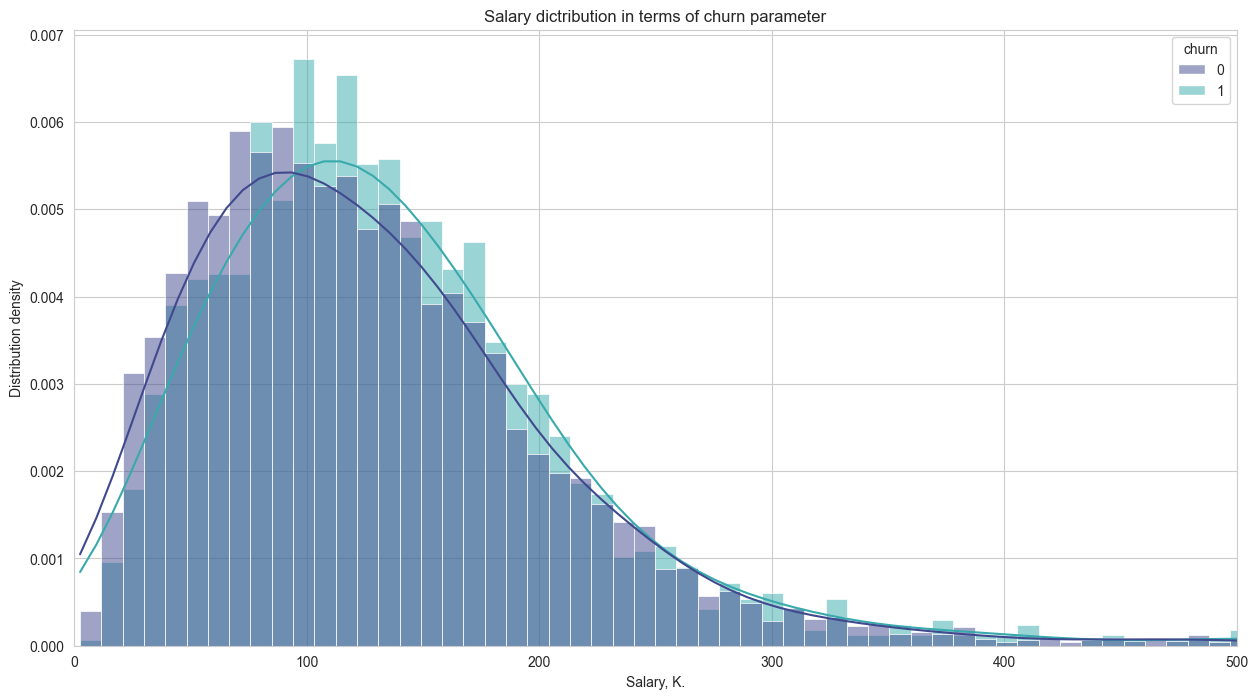

In [59]:
plt.figure(figsize=(15,8))

sns.histplot(x='est_salary_1', data=data, kde=True, hue='churn', palette='mako', stat="density", common_norm=False)
plt.title('Salary dictribution in terms of churn parameter')
plt.xlim(0,500)
plt.ylabel('Distribution density')
plt.xlabel('Salary, K.')
plt.show()

- Here **there is a minimal difference**, slightly higher than churn clients with salaries in the range of 100k to 150k. However, I would go on record as saying that the distributions are identical.

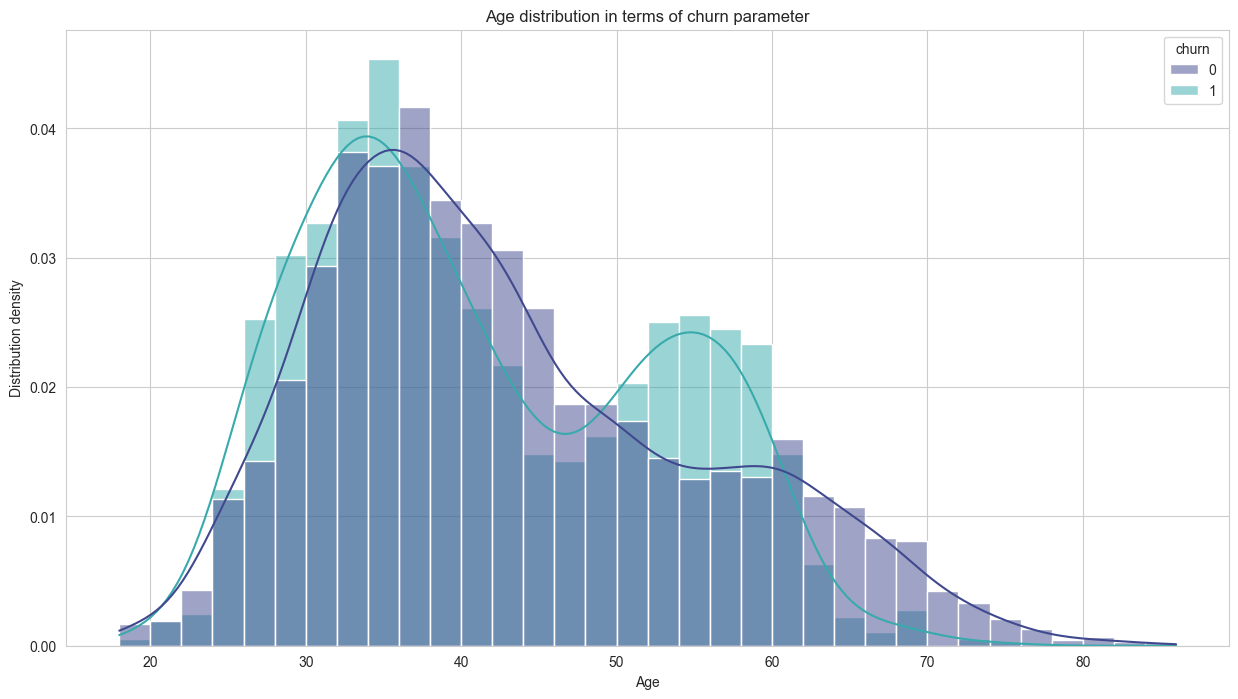

In [60]:
plt.figure(figsize=(15,8))

sns.histplot(x='age', data=data, kde=True, hue='churn', palette='mako', stat="density", common_norm=False, binwidth = 2)
plt.title('Age distribution in terms of churn parameter')
plt.ylabel('Distribution density')
plt.xlabel('Age')
plt.show()

- There are *two "bells"* among **churn** with a slight advantage **in the range of 20 to 35 years** and with a **bigger advantage in the age range of 50 to 60 years**.
- Among **not churn**, the peak and corresponding advantage falls in the range **of 35 to 50 years**, and there is a small jump **of 60 years**.

**Result:**

Explicit signs of **churn** customers:
 - **balance** above 1 mln. rub;
 - **credit score** in the range of 800 to 900 points;
 - **age** less in the range of 20 to 32 years and more in the range of 50 to 60 years;
 - **salary** of such clients in the range from 100k to 200k rubles.
 
**Not churn** users are predominantly those with *up to 1 million*, *with scoring in the 650 to 800 and 900 to 1000 point ranges*, *age 35 to 50 and 60 years old*.     

### Analysis of the churn rate by categories

- Let's do a grouping by *category data* - last_activity, credit_card, gender, city, and additionally by *quantitative data* - products, equity with aggregation by the average in terms of churn parameter.
- Based on the grouped data, let's construct bar charts with additional information on the average level of churn parameter for the bank.

In [61]:
# average level of churn parameter for the bank
mean_churn = round(data['churn'].mean(), 3)
mean_churn

0.182

In [62]:
def get_grouped_tables(params):
    
    '''
    function for generating pivot tables by parameters
    params - list of parameters
    '''
    
    tables = []
    for param in params:
        table = data.groupby(param, as_index=False).agg({'churn':['mean','count']})
        table.columns = [param, 'mean', 'count']
        table = table.sort_values(by='count', ascending=False)
        table['diff_per'] = round(table['mean'] - mean_churn, 2) * 100
        tables.append(table)
        
    return tables    

In [63]:
params = ['credit_card', 'last_activity','city', 'gender', 'products', 'equity']
tables = get_grouped_tables(params)

credit_card = tables[0]
last_activity = tables[1]
city = tables[2]
gender = tables[3]
products = tables[4]
equity = tables[5]

credit_card.loc[credit_card['credit_card'] == 0, 'credit_card'] = 'no credit card'
credit_card.loc[credit_card['credit_card'] == 1, 'credit_card'] = 'use credit card'

last_activity.loc[last_activity['last_activity'] == 0, 'last_activity'] = 'inactive'
last_activity.loc[last_activity['last_activity'] == 1, 'last_activity'] = 'active'

In [64]:
credit_card

credit_card      mean  count  diff_per
1  use credit card  0.147413   6804      -3.0
0   no credit card  0.255399   3195       7.0

In [65]:
last_activity

last_activity      mean  count  diff_per
1        active  0.244126   5235       6.0
0      inactive  0.113560   4764      -7.0

In [66]:
city

city      mean  count  diff_per
2  Ярославль  0.189708   5888       1.0
1    Рыбинск  0.161841   2694      -2.0
0     Ростов  0.187721   1417       1.0

In [67]:
gender

gender      mean  count  diff_per
1      М  0.236364   5005       5.0
0      Ж  0.127353   4994      -5.0

In [68]:
products

products      mean  count  diff_per
1         2  0.190987   5126       1.0
0         1  0.070338   3341     -11.0
2         3  0.285852   1039      10.0
3         4  0.632911    474      45.0
4         5  0.421053     19      24.0

In [69]:
equity

equity      mean  count  diff_per
0       0  0.034722   2592     -15.0
5       5  0.300834   1918      12.0
4       4  0.250811   1850       7.0
3       3  0.208171   1542       3.0
2       2  0.157795   1052      -2.0
1       1  0.120155    774      -6.0
6       6  0.360248    161      18.0
7       7  0.462500     80      28.0
8       8  0.352941     17      17.0
9       9  0.538462     13      36.0

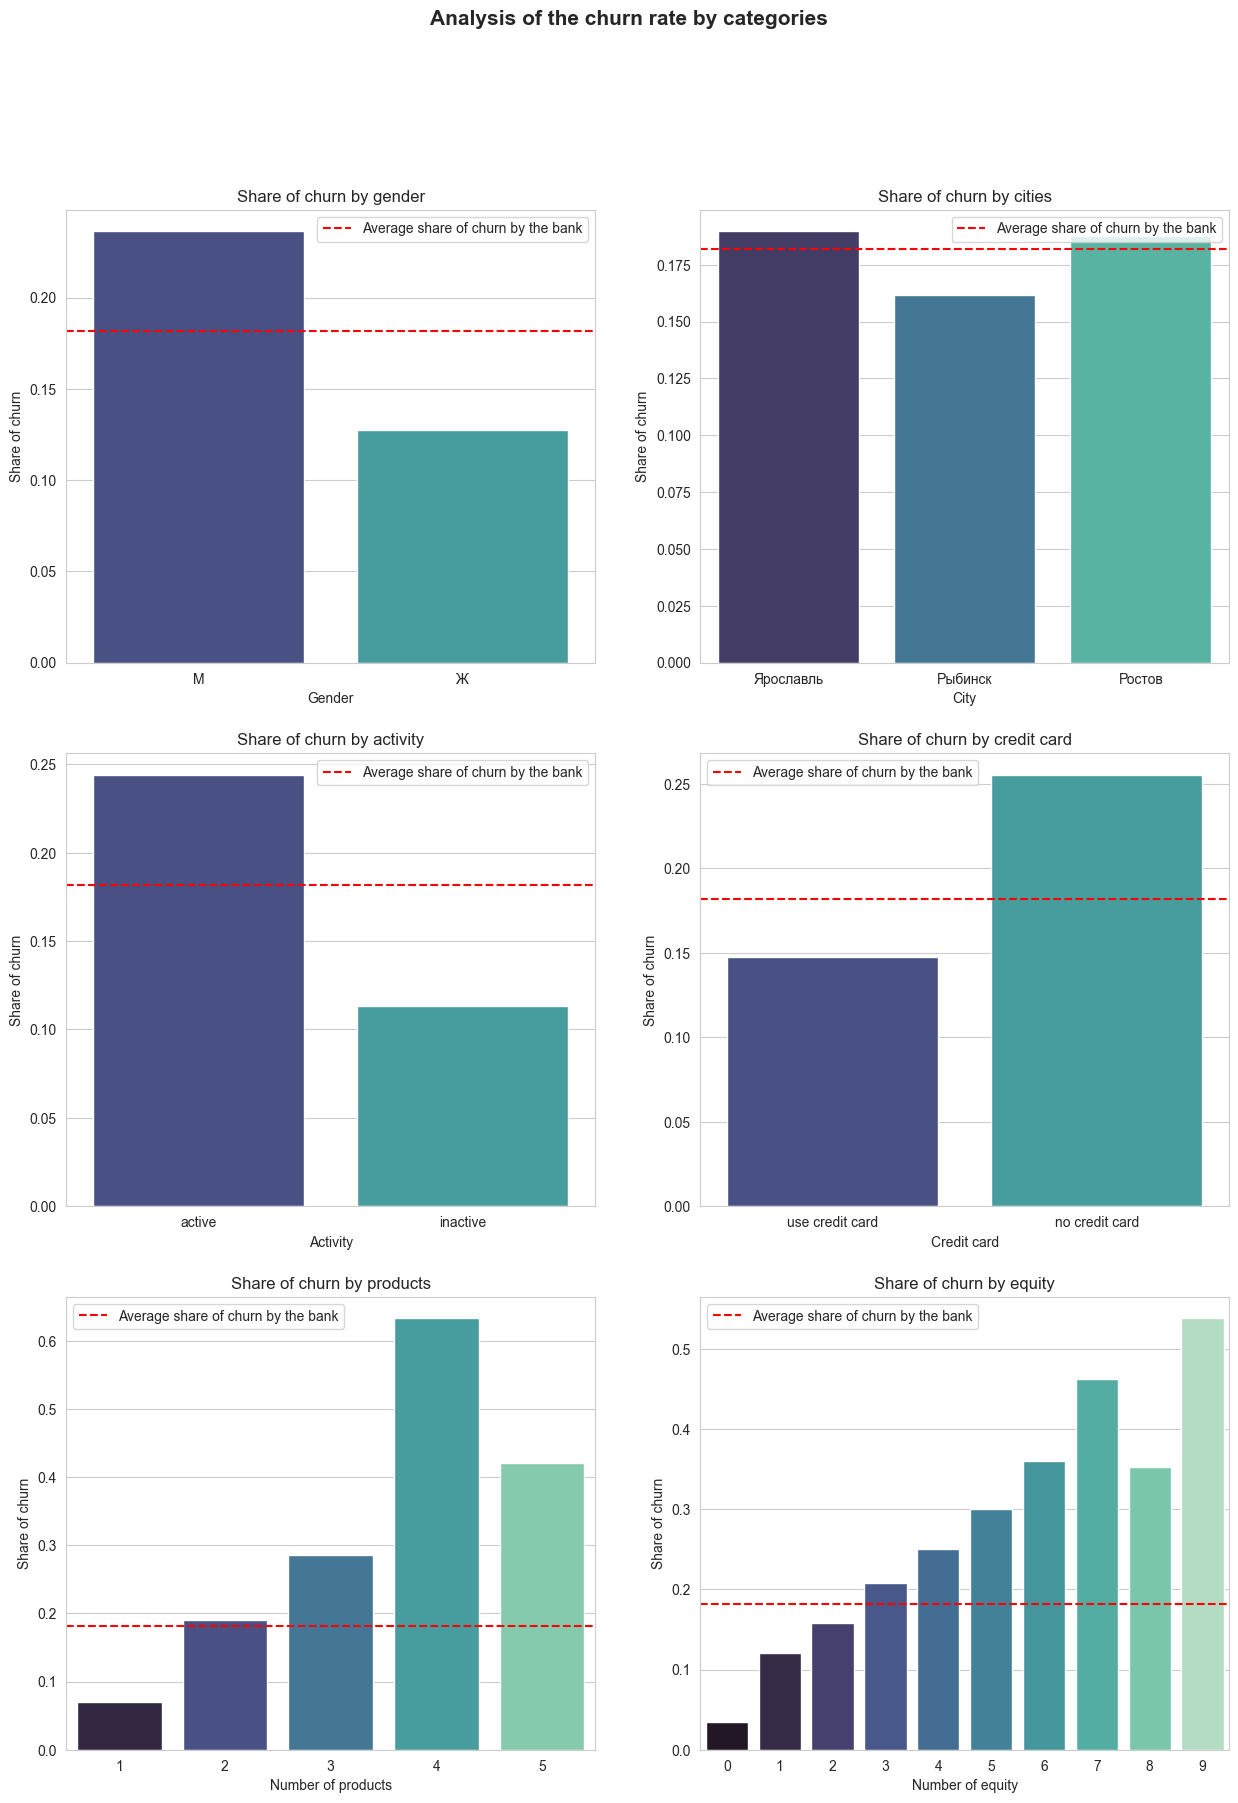

In [70]:
plt.figure(figsize=(15,20))

plt.suptitle('Analysis of the churn rate by categories', fontweight='bold', fontsize=15)
ax1 = plt.subplot(3,2,1)
sns.barplot(x='gender', y='mean', data=gender, palette='mako', ax=ax1)
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Average share of churn by the bank')
plt.title('Share of churn by gender')
plt.xlabel('Gender')
plt.ylabel('Share of churn')
plt.legend()

ax2 = plt.subplot(3,2,2)
sns.barplot(x='city', y='mean', data=city, palette='mako', ax=ax2)
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Average share of churn by the bank')
plt.title('Share of churn by cities')
plt.xlabel('City')
plt.ylabel('Share of churn')
plt.legend()

ax3 = plt.subplot(3,2,3)
sns.barplot(x='last_activity', y='mean', data=last_activity, palette='mako', ax=ax3)
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Average share of churn by the bank')
plt.title('Share of churn by activity')
plt.xlabel('Activity')
plt.ylabel('Share of churn')
plt.legend()

ax4 = plt.subplot(3,2,4)
sns.barplot(x='credit_card', y='mean', data=credit_card, palette='mako', ax=ax4)
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Average share of churn by the bank')
plt.title('Share of churn by credit card')
plt.xlabel('Credit card')
plt.ylabel('Share of churn')
plt.legend()

ax5 = plt.subplot(3,2,5)
sns.barplot(x='products', y='mean', data=products, palette='mako', ax=ax5)
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Average share of churn by the bank')
plt.title('Share of churn by products')
plt.xlabel('Number of products')
plt.ylabel('Share of churn')
plt.legend()

ax6 = plt.subplot(3,2,6)
sns.barplot(x='equity', y='mean', data=equity, palette='mako', ax=ax6)
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Average share of churn by the bank')
plt.title('Share of churn by equity')
plt.xlabel('Number of equity')
plt.ylabel('Share of churn')
plt.legend()

plt.show()

**Result:**

Parameters that **exceed the bank's average churn rate**
- **men** (over 5%)
- **active users** (over 6%)
- users **without credit card** (over 7%) 
- users who use **two or more products**: the more products, the higher the churn rate. Users with 2 products are 1% above the average churn rate, with 3 - over 10%, **with 4 - over 45%** (!), with 5 - over 24%.
- users with **three or more equities** (3% to 36%): the more equities, the higher the churn rate, more than the others exceed the average churn rate of users with 9 equities - by 36%.
- users from **Yaroslavl and Rostov** exceed the bank's average churn rate by **only 1%**.

In addition, it is worth considering that the number of users decreases as the number of products and equity increases, so the calculated shares there are higher.

### Correlation analysis

In [71]:
data_1 = data.drop(['user_id', 'city', 'gender', 'balance', 'est_salary'], axis=1)
data_1.rename(columns={'balance_1' :'balance',
                      'est_salary_1':'est_salary'}, inplace = True)

interval_cols = ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 
                 'last_activity', 'est_salary', 'churn', 'is_female', 'is_male', 
                 'is_Rostov', 'is_Rybinsk', 'is_Yaroslavl', 'balance', 'est_salary']
churn_phik = data_1.phik_matrix(interval_cols=interval_cols)

churn_phik.round(2)

score   age  equity  products  credit_card  last_activity  \
score           1.00  0.04    0.53      0.42         0.21           0.05   
age             0.04  1.00    0.04      0.14         0.16           0.09   
equity          0.53  0.04    1.00      0.58         0.22           0.05   
products        0.42  0.14    0.58      1.00         0.27           0.11   
credit_card     0.21  0.16    0.22      0.27         1.00           0.05   
last_activity   0.05  0.09    0.05      0.11         0.05           1.00   
churn           0.23  0.18    0.35      0.26         0.20           0.26   
is_female       0.07  0.29    0.06      0.07         0.20           0.01   
is_male         0.07  0.29    0.06      0.07         0.20           0.01   
is_Rostov       0.09  0.07    0.07      0.05         0.15           0.00   
is_Rybinsk      0.03  0.06    0.00      0.08         0.08           0.07   
is_Yaroslavl    0.08  0.10    0.05      0.11         0.18           0.08   
balance         0.17  0.03    0.00      0.00         0.00           0.00   
est_salary      0.40  0.36    0.29      0.22         0.04           0.05   

               churn  is_female  is_male  is_Rostov  is_Rybinsk  is_Yaroslavl  \
score           0.23       0.07     0.07       0.09        0.03          0.08   
age             0.18       0.29     0.29       0.07        0.06          0.10   
equity          0.35       0.06     0.06       0.07        0.00          0.05   
products        0.26       0.07     0.07       0.05        0.08          0.11   
credit_card     0.20       0.20     0.20       0.15        0.08          0.18   
last_activity   0.26       0.01     0.01       0.00        0.07          0.08   
churn           1.00       0.22     0.22       0.00        0.05          0.03   
is_female       0.22       1.00     1.00       0.02        0.02          0.04   
is_male         0.22       1.00     1.00       0.02        0.02          0.04   
is_Rostov       0.00       0.02     0.02       1.00        0.38          0.69   
is_Rybinsk      0.05       0.02     0.02       0.38        1.00          0.91   
is_Yaroslavl    0.03       0.04     0.04       0.69        0.91          1.00   
balance         0.02       0.05     0.05       0.00        0.02          0.05   
est_salary      0.05       0.14     0.14       0.14        0.10          0.18   

               balance  est_salary  
score             0.17        0.40  
age               0.03        0.36  
equity            0.00        0.29  
products          0.00        0.22  
credit_card       0.00        0.04  
last_activity     0.00        0.05  
churn             0.02        0.05  
is_female         0.05        0.14  
is_male           0.05        0.14  
is_Rostov         0.00        0.14  
is_Rybinsk        0.02        0.10  
is_Yaroslavl      0.05        0.18  
balance           1.00        0.37  
est_salary        0.37        1.00

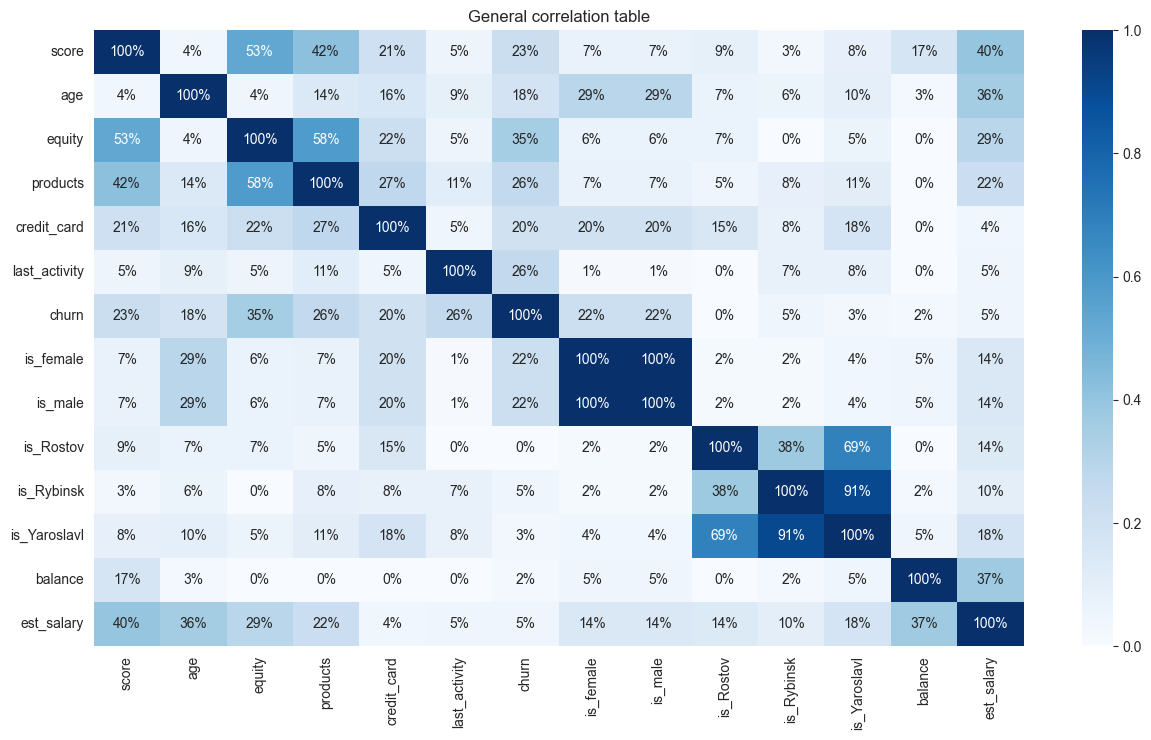

In [72]:
plt.figure(figsize=(15,8))

sns.heatmap(churn_phik, cmap="Blues", annot=True, fmt=".0%")
plt.title('General correlation table')

plt.show()

Let's separate out the churn column.

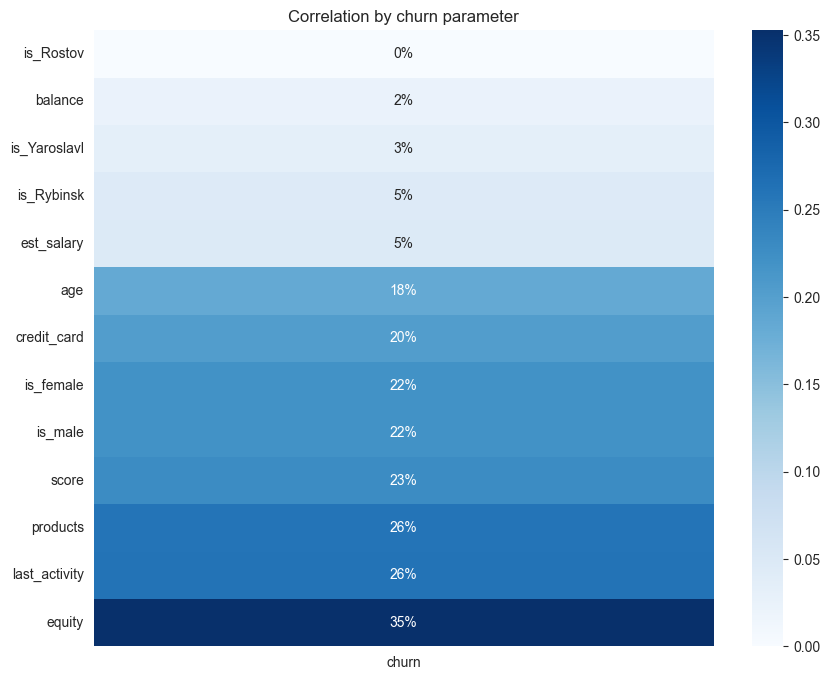

In [73]:
plt.figure(figsize=(10,8))

sns.heatmap(churn_phik.loc[:,['churn']].drop('churn').sort_values('churn'), cmap="Blues", annot=True, fmt=".0%")
plt.title('Correlation by churn parameter')

plt.show()

According to the Chaddock scale, a correlation score of **0 to 30%** characterizes a **negligible correlation**, **30 to 50% is weak correlation**, **50 to 70% - moderate correlation**, **70 to 90% - strong correlation**, **90 to 100% is the strongest**. As a result, the following conclusions can be drawn:
- churn rate has **the most negligible correlation** with **cities (0% - 5%)**, **balance (2%)** and **salary (5%)**; 
- a **negligible correlation** is formed from **age (18%)**, having a **credit card (20%)**, **gender (same reliance at 22%)**, **credit scoring (23%)**, **number of products (26%)**, and **user activity (26%)**;
- a **weak correlation of 35%** is formed with **equity**.


Due to the distributions studied in section 2.2 we know, that **starting with 1 million on the balance sheet, churn is clearly prevalent** and to see a balance sheet with 2% in the correlation is odd. Let's use the pd.qcut method and divide the balance sheet data into 8 intervals (percentiles) and re-build the correlation tables.

In [74]:
data_1['balance_bins'] = pd.qcut(x=data_1['balance'], q=8, precision=0)

data_1['balance_bins'].value_counts()

(-0.1, 0.2]     964
(0.2, 0.3]      963
(0.3, 0.4]      963
(0.4, 0.5]      963
(0.5, 0.7]      963
(0.7, 1.0]      963
(1.0, 1.4]      963
(1.4, 119.1]    963
Name: balance_bins, dtype: int64

In [75]:
interval_cols = ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 
                 'last_activity', 'est_salary', 'churn', 'is_female', 'is_male', 
                 'is_Rostov', 'is_Rybinsk', 'is_Yaroslavl', 'balance', 'est_salary']
churn_phik = data_1.phik_matrix(interval_cols=interval_cols)

churn_phik.round(2)

score   age  equity  products  credit_card  last_activity  \
score           1.00  0.04    0.53      0.42         0.21           0.05   
age             0.04  1.00    0.04      0.14         0.16           0.09   
equity          0.53  0.04    1.00      0.58         0.22           0.05   
products        0.42  0.14    0.58      1.00         0.27           0.11   
credit_card     0.21  0.16    0.22      0.27         1.00           0.05   
last_activity   0.05  0.09    0.05      0.11         0.05           1.00   
churn           0.23  0.18    0.35      0.26         0.20           0.26   
is_female       0.07  0.29    0.06      0.07         0.20           0.01   
is_male         0.07  0.29    0.06      0.07         0.20           0.01   
is_Rostov       0.09  0.07    0.07      0.05         0.15           0.00   
is_Rybinsk      0.03  0.06    0.00      0.08         0.08           0.07   
is_Yaroslavl    0.08  0.10    0.05      0.11         0.18           0.08   
balance         0.17  0.03    0.00      0.00         0.00           0.00   
est_salary      0.40  0.36    0.29      0.22         0.04           0.05   
balance_bins    0.41  0.26    0.49      0.19         0.22           0.00   

               churn  is_female  is_male  is_Rostov  is_Rybinsk  is_Yaroslavl  \
score           0.23       0.07     0.07       0.09        0.03          0.08   
age             0.18       0.29     0.29       0.07        0.06          0.10   
equity          0.35       0.06     0.06       0.07        0.00          0.05   
products        0.26       0.07     0.07       0.05        0.08          0.11   
credit_card     0.20       0.20     0.20       0.15        0.08          0.18   
last_activity   0.26       0.01     0.01       0.00        0.07          0.08   
churn           1.00       0.22     0.22       0.00        0.05          0.03   
is_female       0.22       1.00     1.00       0.02        0.02          0.04   
is_male         0.22       1.00     1.00       0.02        0.02          0.04   
is_Rostov       0.00       0.02     0.02       1.00        0.38          0.69   
is_Rybinsk      0.05       0.02     0.02       0.38        1.00          0.91   
is_Yaroslavl    0.03       0.04     0.04       0.69        0.91          1.00   
balance         0.02       0.05     0.05       0.00        0.02          0.05   
est_salary      0.05       0.14     0.14       0.14        0.10          0.18   
balance_bins    0.31       0.11     0.11       0.09        0.01          0.09   

               balance  est_salary  balance_bins  
score             0.17        0.40          0.41  
age               0.03        0.36          0.26  
equity            0.00        0.29          0.49  
products          0.00        0.22          0.19  
credit_card       0.00        0.04          0.22  
last_activity     0.00        0.05          0.00  
churn             0.02        0.05          0.31  
is_female         0.05        0.14          0.11  
is_male           0.05        0.14          0.11  
is_Rostov         0.00        0.14          0.09  
is_Rybinsk        0.02        0.10          0.01  
is_Yaroslavl      0.05        0.18          0.09  
balance           1.00        0.37          0.09  
est_salary        0.37        1.00          0.30  
balance_bins      0.09        0.30          1.00

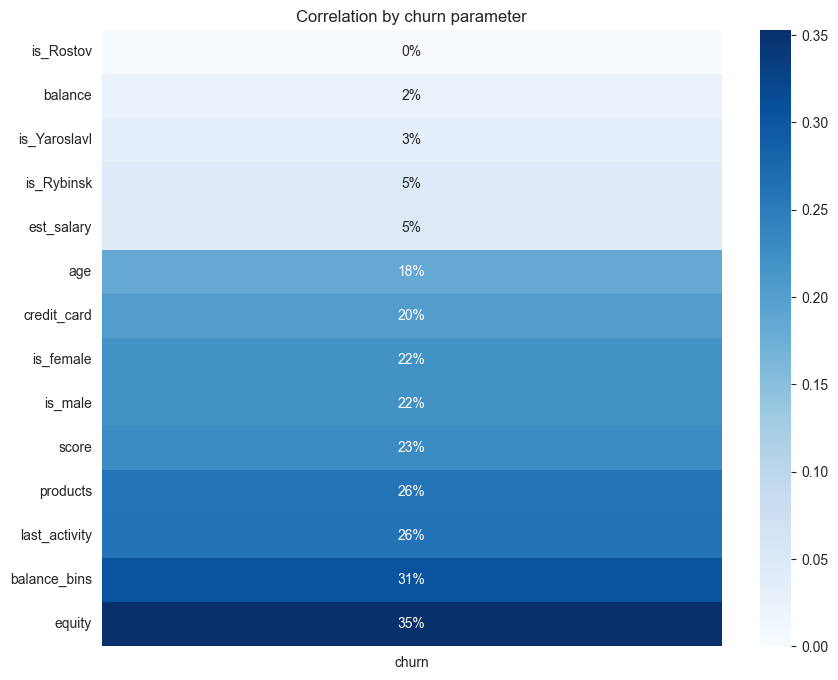

In [76]:
plt.figure(figsize=(10,8))

sns.heatmap(churn_phik.loc[:,['churn']].drop('churn').sort_values('churn'), cmap="Blues", annot=True, fmt=".0%")
plt.title('Correlation by churn parameter')

plt.show()

As hypothesized, by **balance** there is a **weak correlation of 31%**. 

### General conclusion


**1) Users profiles**

**Exactly what influences the churn are: balance, user activity, eqyity - all these variables have an advantage of more than 30% relative to not churn variables.** Will also keep in mind that there are more churn users in Yaroslavl and Rostov, and they are predominantly men; **an important preference among not churn users is the availability of a credit card**.

**2) Distribution of continuous**
  - balance: **beginning with 1 million on the balance sheet, churn is clearly prevalent**, **not churn** users are predominantly those with balances up to 1 million;  
  - credit score: **churn users** have credit score in the range **of 830 to 940**, **not churn** - **of 650 to 800** and **of 900 to 1000** points;
  - salary: according to the graphs, the distributions are almost identical (statistical hypothesis testing is required);
  - age: there are *two "bells"* among **churn** with a slight advantage **in the range of 20 to 35 years** (will additionally test the statistical hypothesis) and with a **bigger advantage in the age range of 50 to 60 years**. Among **not churn**, the peak and corresponding advantage falls in the range **of 35 to 50 years**, and there is a small jump **of 60 years**.

**3) The churn rate by categories**

 Parameters that **exceed the bank's average churn rate**
- **men** (over 5%)
- **active users** (over 6%)
- users **without credit card** (over 7%) 
- users who use **two or more products**: the more products, the higher the churn rate. Users with 2 products are 1% above the average churn rate, with 3 - over 10%, **with 4 - over 45%** (!), with 5 - over 24%.
- users with **three or more equities** (3% to 36%): the more equities, the higher the churn rate, more than the others exceed the average churn rate of users with 9 equities - by 36%.
- users from **Yaroslavl and Rostov** exceed the bank's average churn rate by **only 1%**.

**4) Correlation analysis**

- churn rate has **the most negligible correlation** with **cities (0% - 5%)** and **salary (5%)**; 
- a **negligible correlation** is formed from **age (18%)**, having a **credit card (20%)**, **gender (same reliance at 22%)**, **credit scoring (23%)**, **number of products (26%)**, and **user activity (26%)**;
- a **weak correlation of 35%** is formed with **equity** (35%) and **balance** (31%).


Next, statistical hypothesis testing will need to be performed to confirm or reject the difference between churned and non-churned customers on the following measures:
 - Salary. Because there is a minimal difference on density distribution plots between churn and non-churn parameters
 - Age in the range of 20 to 35 years. There is also a minimal difference between churn and non-churn parameter on density distributon plot.
 - Products. Having two products is more of a churn or non-churn indicator?
 - Cities. Yaroslavl and Rostov have a churn rate above the bank's average, but the difference is one percent.

## Statistical hypothesis testing

### Hypothesis of equality of average income of churn and non-churn customers

The *scipy.stats.ttest_ind()* method will be used to test this hypothesis.

- Н0 - average income of churn customers is equal to average income of non-churn customers
- Н1 - average income of churn customers is not equal to average income of non-churn customers

In [77]:
churn_salary = churn['est_salary_1']
not_churn_salary = not_churn['est_salary_1']
print(f'Sample length by churn customers {len(churn_salary)}')
print(f'Sample length by non-churn customers {len(not_churn_salary)}')

Sample length by churn customers 1819
Sample length by non-churn customers 8180


The samples are of different sizes, so we additionally specify the parameter equal_var=False

In [78]:
alpha = 0.05

salary_result = st.ttest_ind(churn_salary, not_churn_salary, equal_var=False)
print('p-value', salary_result.pvalue)
if (salary_result.pvalue < alpha):
    print('Rejecting the Null Hypothesis')
else:
    print('Do not reject the Null Hypothesis') 

p-value 0.8724727072323828
Do not reject the Null Hypothesis


According to the test performed, the hypothesis of **equality of average income of churn and non-churn customers is not rejected**.

Let's test the normality of the salary distribution.

In [79]:
alpha = 0.05  # critical level of statistical significance

print('Test the normality of churn salary distribution')
results = st.shapiro(churn_salary)
p_value = results[1]  # the second value in the result array (with index 1) - p-value

print('p-value: ', p_value)

if p_value < alpha:
    print('Reject the null hypothesis: the distribution is not normal')
else:
    print('Failed to reject the null hypothesis')
    
print()
print('Test the normality of non-churn salary distribution')
results = st.shapiro(not_churn_salary)
p_value = results[1]  # the second value in the result array (with index 1) - p-value

print('p-value: ', p_value)

if p_value < alpha:
    print('Reject the null hypothesis: the distribution is not normal')
else:
    print('Failed to reject the null hypothesis')    

Test the normality of churn salary distribution
p-value:  0.0
Reject the null hypothesis: the distribution is not normal

Test the normality of non-churn salary distribution
p-value:  0.0
Reject the null hypothesis: the distribution is not normal


The distributions of salaries among churn and non-churn customers don't have a normal distribution.In order for the t-test to work correctly, we need **the distribution of averages to be normal**.

Let's perform a non-parametric Mann-Whitney test.

In [80]:
alpha = 0.05  # critical level of statistical significance

results = st.mannwhitneyu(churn_salary, not_churn_salary)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print('Reject the Null Hypothesis: the difference is statistically significant')
else:
    print(
        'Failed to reject the Null Hypothesis, no conclusion about the difference can be drawn'
    ) 

p-value:  0.0002116065220362306
Reject the Null Hypothesis: the difference is statistically significant


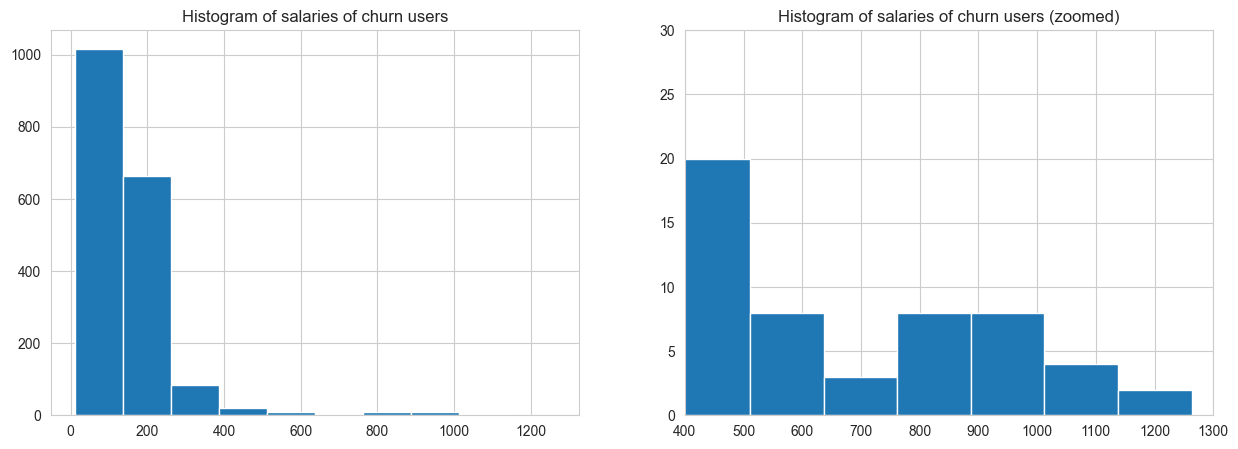

In [81]:
plt.figure(figsize=(15,5))

ax1 = plt.subplot(1,2,1)
churn['est_salary_1'].hist(ax=ax1)
plt.title('Histogram of salaries of churn users')

ax2 = plt.subplot(1,2,2)
churn['est_salary_1'].hist(ax=ax2)
plt.title('Histogram of salaries of churn users (zoomed)')
plt.xlim(400,1300)
plt.ylim(0,30)

plt.show()

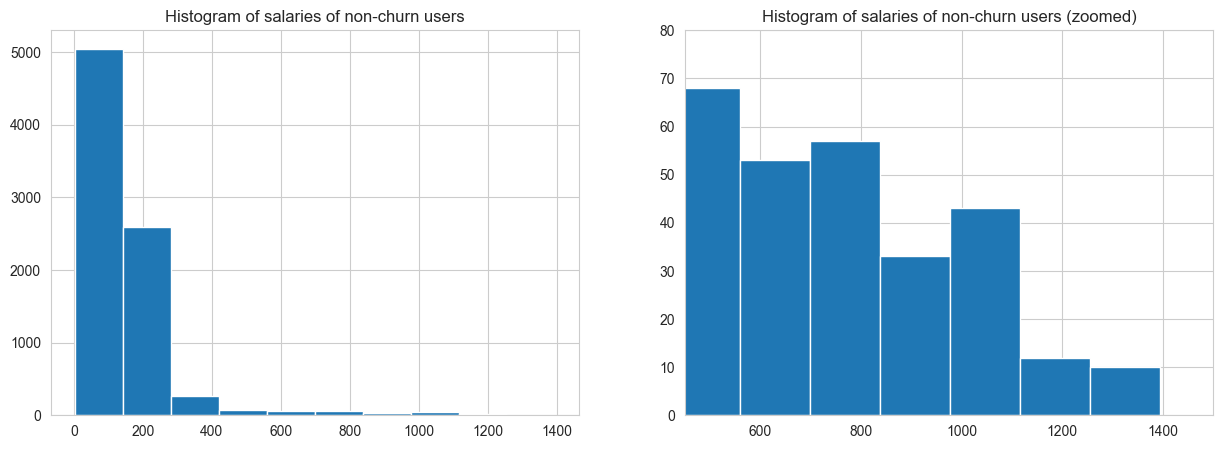

In [82]:
plt.figure(figsize=(15,5))

ax1 = plt.subplot(1,2,1)
not_churn['est_salary_1'].hist(ax=ax1)
plt.title('Histogram of salaries of non-churn users')

ax2 = plt.subplot(1,2,2)
not_churn['est_salary_1'].hist(ax=ax2)
plt.title('Histogram of salaries of non-churn users (zoomed)')
plt.xlim(450,1500)
plt.ylim(0,80)

plt.show()

The non-parametric test yielded a result that **rejectes the hypothesis that the salaries of churn and non-churn users are equal**. If you look at the mini-histograms you can really see the difference in the number of outliers - non-churn users have more of them.

**Result:** in this case, the Mann-Whitney test result has more weight, outliers affect the results - **there is a difference between the average salary of churn and non-churn users**, will take this into account when segmenting.

### Hypothesis of equality of age shares among churn and non-churn users.

The distribution plot by churn shows little difference between 20 and 35 years of age. Let's check if there is a difference using the z-test.

- Н0 - there are no statistically significant differences between the shares.
- Н1 - there are statistically significant differences between the shares.

In [83]:
churn_len = len(churn['age'])
not_churn_len = len(not_churn['age'])

churn_products_count = churn.query('age >= 20 and age <= 35')['age'].count()
not_churn_products_count = not_churn.query('age >= 20 and age <= 35')['age'].count()

p1 = churn_products_count/churn_len
p2 = not_churn_products_count/not_churn_len

difference = p1 - p2 

# The proportion of successes in the combined dataset:
p_combined = (churn_products_count + not_churn_products_count) / (churn_len + not_churn_len)

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/churn_len+ 1/not_churn_len))

distr = st.norm(0, 1)

p_value = round((1 - distr.cdf(abs(z_value))) * 2,3)

print('p-value: ', p_value)

if p_value < alpha:
    print('Reject the Null Hypothesis: there is a significant difference between the shares')
else:
    print('Failed to reject the Null Hypothesis, there is no reason to consider the shares to be different' ) 

p-value:  0.0
Reject the Null Hypothesis: there is a significant difference between the shares


**Result:** the test result showed that **there is a statistically significant difference** between the proportions of churn and non-churn users aged 20 to 35.

### Product hypothesis: equality of the shares of churned and non-churned users with the two products.

When analyzing the level of churn by category in the graph with products, the line for the average churn rate per bank ran very close with the bar with the two products. We need to check whether the presence of two products is a statistically significant indicator of churn.

- Н0 - there are no statistically significant differences between the shares.
- Н1 - there are statistically significant differences between the shares.

In [84]:
churn_len = len(churn['products'])
not_churn_len = len(not_churn['products'])

churn_products_count = churn.query('products == 2')['products'].count()
not_churn_products_count = not_churn.query('products == 2')['products'].count()

p1 = churn_products_count/churn_len
p2 = not_churn_products_count/not_churn_len

difference = p1 - p2 

# The proportion of successes in the combined dataset:
p_combined = (churn_products_count + not_churn_products_count) / (churn_len + not_churn_len)

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/churn_len+ 1/not_churn_len))

distr = st.norm(0, 1)

p_value = round((1 - distr.cdf(abs(z_value))) * 2,3)

print('p-value: ', p_value)

if p_value < alpha:
    print('Reject the Null Hypothesis: there is a significant difference between the shares')
else:
    print('Failed to reject the Null Hypothesis, there is no reason to consider the shares to be different' ) 

p-value:  0.016
Reject the Null Hypothesis: there is a significant difference between the shares


**Result:** **there is a significant difference** between the shares of churn and non-churn users with two products.

### Hypothesis about cities: equality of shares of churn and non-churn users in Yaroslavl and Rostov.

In [85]:
def get_city_test_result(city):
    # sample sizes
    n1 = len(churn[city])
    n2 = len(not_churn[city])

    # success rates
    p1 = churn[city].mean()
    p2 = not_churn[city].mean()

    # dataset proportion difference
    difference = p1 - p2 
    
    # proportion of successes in the combined dataset:
    p_combined = (churn[city].sum() + not_churn[city].sum()) / (n1 + n2)
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/n1+ 1/n2))

    distr = st.norm(0, 1)

    p_value = round((1 - distr.cdf(abs(z_value))) * 2,3)

    print('p-value: ', p_value)

    if p_value < alpha:
        print('Reject the Null Hypothesis: there is a significant difference between the shares')
    else:
        print('Failed to reject the Null Hypothesis, there is no reason to consider the shares to be different') 

- Н0 - there are no statistically significant differences between the shares of users in Rostov.
- Н1 - between the shares there are statistically significant differences among users in Rostov.

In [86]:
# share difference in Rostov
get_city_test_result('is_Rostov')

p-value:  0.541
Failed to reject the Null Hypothesis, there is no reason to consider the shares to be different


- Н0 - there are no statistically significant differences between the shares of users in Yaroslavl.
- Н1 - between the shares there are statistically significant differences among users in Yaroslavl.

In [87]:
# share difference in Yaroslavl
get_city_test_result('is_Yaroslavl')

p-value:  0.016
Reject the Null Hypothesis: there is a significant difference between the shares


**Result:** the hypothesis about the equality of shares of churn and non-churn users in Yaroslavl was rejected, in Rostov - not rejected. We assume that more churn users live in Yaroslavl.

### General conclusion

As a result of testing the hypotheses, the following points were clarified:
 - salary level affects the churn rate - cccording to the distribution plot (p.2.2), churn users have salaries ranging from 100 to 250K;
 - users between 20 and 35 years old are mostly churn;
 - having two products is also a hallmark of churn users;
 - more churn users live in Yaroslavl.


## Summarizing the intermediate result

- **Balance**: **correlation dependence** weak - 31%, according to the user profile, the advantage is more than 60% relative to non-churn users; according to the distribution plot **user churn is observed from 1 million rubles on the account**.
- **Salary**: Hypothesis testing confirmed the existence of a difference between churn and non-churn users, so we can assume that **salary affect the churn rate**. According to the distribution plot churn users have salary in the range **from 100 to 250 K**.
- **Credit score**: **the correlation with churn parameter** is 23%, with a range of churn user scores **from 830 to 940**.
- **Equity**: the **correlation with churn parameter** - 35%. Users with **3** equitues exceed the average churn rate **by 3% (total users 1542)**, **with 4 by 7% (1850)**, **with 5 by 12% (1918)**, **with 6 by 18% (161)**, **with 7 by 28%(80)**, **with 8 by 17% (17)**, **with 9 by 36% (13). 
- **Products**: **the correlation with churn parameter** - 26%. After testing the statistical hypotheses about the difference in the proportion of churn and non-churn users, it was decided that the parameter *presence of two products* should be considered as *influencing churn*. According to the analysis of the churn rate by category, users **with 2 products exceed the average churn rate by 1% (5126 users in total)**, **with 3 products by 10% (1039)**, **with 4 products by 45% (474)**, **with 5 products by 24% (19)**. 
- **Last activity**: **the correlation** - 26%, active users **exceed** the bank's average churn rate by **6%**.
- **Credit card**: users **without credit cards** exceed the average churn rate for the bank by 7%, the correlation is 20%.
- **Age**: age has a **correlation of 18%** with churn, the most pronounced **explicit age diapasons** among churn users are **20-35 years** (the difference was proved by checking the z-test shares) and **50-60 years**.
- **Gender**: both women and men have a correlation with churn of 22%, but **the proportion of "male" churn exceeds the bank's average churn rate by 5%**.
- **City**: cities have a very low correlation with churn rate - from 0 to 5%, **the average level of churn rate is exceeded in Rostov and Yaroslavl**, but after the z-test it turned out that **in Rostov the shares of churn and non-churn users coincide, and in Yarosla not**.).

## Segmentation based on strategic indicators

Highlighting key features that increase churn while decreasing segmentation.

Requirement: Prerequisite: the segments should not be very large - more than 2 000 people, and too small - less than 300 people.

### Segmentation

**Segment №1**

- Balance more than 1 mln. rub.
- Without credit card.
- Use 2 and more produts.

In [88]:
seg_balance = data.query('balance_1 > 1 and credit_card == 0 and products > 1' )\
                .agg({'churn':['mean','count','sum'],
                     'is_male':['mean','count','sum'],
                     'is_female':['mean','count','sum'],
                     'is_Yaroslavl':['mean', 'count','sum'],
                     'is_Rostov':['mean', 'count','sum'],
                     'is_Rybinsk':['mean', 'count','sum']})

seg_balance.loc['mean',:] = round(seg_balance.loc['mean',:] * 100,2)
seg_balance

churn  is_male  is_female  is_Yaroslavl  is_Rostov  is_Rybinsk
mean    44.16    49.33      50.67         60.56      13.93       25.51
count  890.00   890.00     890.00        890.00     890.00      890.00
sum    393.00   439.00     451.00        539.00     124.00      227.00

- The share of **users** who **don't use a credit card** use two or more bank products **with a balance of more than 1 million rubles**, **is 44.16%**. There is no gender difference, more than 60% of such users reside in Yaroslavl.

**Segment №2**

- Credit score in the range of 830 to 940.
- Without credit card.
- Active. 
- Use 2 and more bank products.

In [89]:
seg_score = data.query('(score > 830 and score < 940) and credit_card == 0 and last_activity == 1 and products > 1')\
                .agg({'churn':['mean','count','sum'],
                     'is_male':['mean','count','sum'],
                     'is_female':['mean','count','sum'],
                     'is_Yaroslavl':['mean', 'count','sum'],
                     'is_Rostov':['mean', 'count','sum'],
                     'is_Rybinsk':['mean', 'count','sum']})

seg_score.loc['mean',:] = round(seg_score.loc['mean',:] * 100,2)
seg_score

churn  is_male  is_female  is_Yaroslavl  is_Rostov  is_Rybinsk
mean    56.9    40.61      59.39         51.24      14.82       33.94
count  884.0   884.00     884.00        884.00     884.00      884.00
sum    503.0   359.00     525.00        453.00     131.00      300.00

- The share of **churn active users** who **do not use a credit card**, use two or more of the bank's products **with credit scores in the range of 830 - 940**, **is 56.9%**. In this category, women prevail by 10% (59.39%), and almost 52% of such users live in Yaroslavl.

**Сегмент №3**

- Age in the range of 20-35 and 50-60.
- Without credit card.
- Use 2 and more products.

In [90]:
seg_age = data.query('((age > 50 and age < 60) or (age > 20 and age < 35)) and credit_card == 0 and products > 1')\
                .agg({'churn':['mean','count','sum'],
                     'is_male':['mean','count','sum'],
                     'is_female':['mean','count','sum'],
                     'is_Yaroslavl':['mean', 'count','sum'],
                     'is_Rostov':['mean', 'count','sum'],
                     'is_Rybinsk':['mean', 'count','sum']})

seg_age.loc['mean',:] = round(seg_age.loc['mean',:] * 100,2)
seg_age

churn  is_male  is_female  is_Yaroslavl  is_Rostov  is_Rybinsk
mean     40.71    42.62      57.38         52.08      16.84       31.08
count  1152.00  1152.00    1152.00       1152.00    1152.00     1152.00
sum     469.00   491.00     661.00        600.00     194.00      358.00

- The share of users who **don't use a credit card**, use two or more products of the bank **with the age of 20-35 and 50-60 years**, **is 40.71%**. In this category, women prevail by 5% (57.38%), 52% of such users live in Yaroslavl.

In [91]:
df=data
qrys = (
    'balance_1 > 1 and credit_card == 0 and products > 1',
    '(score > 830 and score < 940) and credit_card == 0 and last_activity == 1 and products > 1',
    '((age > 50 and age < 60) or (age > 20 and age < 35)) and credit_card == 0 and products > 1 ')

df_results = pd.concat([
    pd.DataFrame(df.query(q).agg({"churn":['mean','count']}).values,
                 columns=[q],
                 index=['Churn','Size']).T 
    for q in qrys])

display(df_results.style.format("{:.1%}",subset=["Churn"])\
                   .format("{:_.0f}",subset=["Size"]))
    
all_catched = pd.concat([df.query(q) for q in qrys])
all_churn = df.churn.sum()
catched = all_catched.drop_duplicates().churn.sum()
share_catched = catched / all_churn

if len(qrys) != 3:
    print('The results are incorrect, you need the top 3 segments')
    
if df_results['Churn'].min() < df.churn.mean() * 1.5:
    print('Need to change segments: insufficient churn is present')
elif df_results['Churn'].min() < df.churn.mean() * 2:
    print('Some of the segments are not highly churn')
elif df_results['Churn'].max() > df.churn.mean() * 3:
    print('Found churn enough segment')

if df_results['Size'].min() < 300:
    print('Need to change segments: too small segments are present')
    
if all_catched.shape[0] > 5000:
    print("The marketing department will not be able to handle that many customers")
elif all_catched.shape[0] > 3000:
    print("It will be difficult for the marketing department to handle such a large number of customers, its efficiency will decreas")
elif all_catched.shape[0] < 1000:
    print("Segments can be enlarged")

text_churn = f"{catched}/{all_churn} = {share_catched:.1%}"
if share_catched < 1/3:
    print(f"An insufficient number of churn made it into the segments: {text_churn}")
elif share_catched < 1/2:
    print(f"There are in segments: {text_churn}")
elif share_catched < 2/3:
    print(f"Good result, got into the segments: {text_churn}")
else:
    print(f"Great result, the segments hit: {text_churn}")

   

Found churn enough segment
There are in segments: 734/1819 = 40.4%


### Common result

As a result of the analysis and segmentation, 3 segments were identified, each of these segments alternates between the following parameters: the user must be **active**, **without credit card**, **using two products or more**.

**1) The share of churn customers with a balance of more than RUB 1 million is 44.16%**.

**2) The share of churn customers with credit scoring in the range of 830 - 940 is 56.9%**.

**3) The share of churn customers with age between 20-35 and 50-60 years old, is 40.71%**. 

## Conclusions and recommendations for the customer

**Segment №1**: users without a credit card, using two products or more, with a balance of more than 1 million rubles.
 - total number of users 890
 - churn rate - 44.16%

**Recommendations:** users already use bank products, but there is no bank card among them. Perhaps the percentage of bank deposit does not satisfy users, so they leave or vice versa, the bank service is not profitable for users with a balance of more than 1 million rubles - it is necessary to revise package offers to serve this segment of users, additionally offering to issue a credit card.

**Segment №2**: active users, without a credit card, using two products or more, with credit scoring scores in the range of 830 - 940.
 - total number of users 1152
 - churn rate - 56.9%
 
**Recommendations**: reconsider package solutions for users by additionally offering to apply for a credit card, consider new more favorable credit offers and promotions depending on the number of products used by customers.

**Segment №3**: users without a credit card, using two products or more, with ages ranging from 20-35 and 50-60.
 - total users 529
 - churn rate - 40.71%
 
**Recommendations**: revise users' package solutions by additionally offering to sign up for a credit card. Pay attention to the retirement age, possibly offer promotions or package solutions with a focus on pensioners or those who will soon become pensioners :) For the younger segment, consider offers with a focus on entrepreneurship, buying real estate, technology and paying for education (good rates on loans or installments).